# <font color='#0000FF'> Projet 7: Effectuez une prédiction de revenus</font>

## Sommaire

* [Importation des librairies](#import)


* [Missions 1: Résumé des données](#un)


* [Mission 2: Distribution des revenus selon les pays](#deux)


* [Mission 3: Distributions conditionnelles](#trois)


* [Missions 4: Les facteurs de variation du revenu](#quatre)

## Importation des librairies <a class='anchor' id='import'></a>

In [1]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage, ward, fcluster
import scipy.stats as stats
from sklearn import cluster, metrics, decomposition, preprocessing
from sklearn.cluster import KMeans
from numpy import trapz
import scipy.stats as st
from scipy.stats import t, shapiro
from collections import Counter
import json
import time
import os.path
import pylab
import statsmodels.api as sm
import statsmodels.formula.api as smf
from IPython.display import clear_output
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.stats.outliers_influence import variance_inflation_factor


#### Lecture des dataframes

In [2]:
# Gini: https://donnees.banquemondiale.org/indicator/SI.POV.GINI
# GDIM (Global Database on Intergenerational Mobility): https://www.worldbank.org/en/topic/poverty/brief/what-is-the-global-database-on-intergenerational-mobility-gdim
# pop: https://data.worldbank.org/indicator/SP.POP.TOTL

gini = pd.read_csv('data/API_SI.POV.GINI_DS2_en_csv_v2_2708365.csv', header=2, sep=',')
revenus = pd.read_csv('data/data-projet7.csv', sep=',', decimal=',')
pop = pd.read_csv('data/API_SP.POP.TOTL_DS2_en_csv_v2_2708397.csv', header=2, sep=',')
ige = pd.read_csv('data/GDIMMay2018.csv', sep=',')

# Mission 1: Résumé des données <a class='anchor' id='un'></a>

### Dataframe GINI

In [3]:
gini.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Data columns (total 66 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Name    266 non-null    object 
 1   Country Code    266 non-null    object 
 2   Indicator Name  266 non-null    object 
 3   Indicator Code  266 non-null    object 
 4   1960            0 non-null      float64
 5   1961            0 non-null      float64
 6   1962            0 non-null      float64
 7   1963            0 non-null      float64
 8   1964            0 non-null      float64
 9   1965            0 non-null      float64
 10  1966            0 non-null      float64
 11  1967            1 non-null      float64
 12  1968            0 non-null      float64
 13  1969            1 non-null      float64
 14  1970            0 non-null      float64
 15  1971            1 non-null      float64
 16  1972            0 non-null      float64
 17  1973            0 non-null      flo

In [4]:
gini.shape

(266, 66)

In [5]:
gini.head(2)

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,Unnamed: 65
0,Aruba,ABW,Gini index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Africa Eastern and Southern,AFE,Gini index (World Bank estimate),SI.POV.GINI,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


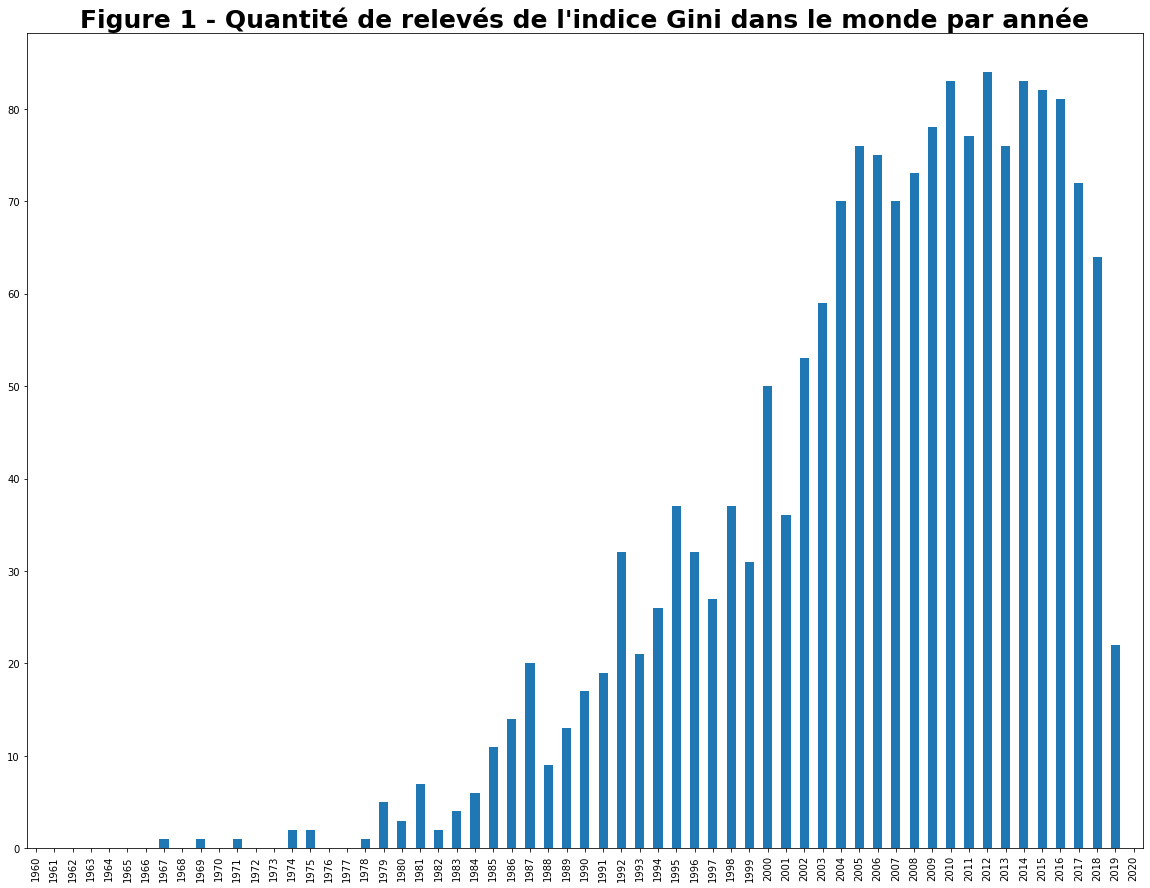

In [6]:
# Tableau en barres des occurences des relevés de l'indice Gini par année.
plt.figure(figsize=(20,15))
gini.iloc[:,4:65][gini.notnull() == True].count().plot(kind='bar')
plt.title('Figure 1 - Quantité de relevés de l\'indice Gini dans le monde par année', fontsize=25, fontweight='bold')
plt.savefig('figure/Figure 1 - Quantité de relevés de l\'indice Gini par année.png', dpi=300)
plt.show()

On constate une augmentation du relevé des indices Gini à partir des années 1980, puis une prédominance de leur utilisation entre 2000 et 2019. Afin d'obtenir une estimation à la fois étendue et d'actualité, nous allons garder les relevés pris à partir de 2000 et calculer la moyenne du coefficient de Gini par pays.

In [7]:
# Ajout d'une colonne calculant la valeur moyenne du coefficient de Gini entre 2000 et 2020.
gini['Gini_mean'] = gini.iloc[:,44:65].mean(axis=1)

In [8]:
gini.rename(columns={'Country Code':'country_code'}, inplace=True)

In [9]:
# Restriction du dataframe aux colonnes les plus pertinentes pour notre recherche
gini_mean = gini[['country_code', 'Gini_mean']]

In [10]:
# Suppression des pays n'ayant aucune information à partir des années 2000.
gini_mean = gini_mean.loc[gini_mean['Gini_mean'].notnull()]

In [11]:
gini_mean.shape

(162, 2)

162 pays ont au moins un coefficient de Gini renseigné à partir de 2000.

In [12]:
gini_mean.head()

,country_code,Gini_mean
4,AGO,48.666667
5,ALB,31.962500
8,ARE,29.250000
9,ARG,45.452632
10,ARM,32.036842


### Dataframe Population

In [13]:
pop.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,Unnamed: 65
0,Aruba,ABW,"Population, total",SP.POP.TOTL,54208.0,55434.0,56234.0,56699.0,57029.0,57357.0,...,102565.0,103165.0,103776.0,104339.0,104865.0,105361.0,105846.0,106310.0,106766.0,NaN
1,Africa Eastern and Southern,AFE,"Population, total",SP.POP.TOTL,130836765.0,134159786.0,137614644.0,141202036.0,144920186.0,148769974.0,...,547482863.0,562601578.0,578075373.0,593871847.0,609978946.0,626392880.0,643090131.0,660046272.0,677243299.0,NaN
2,Afghanistan,AFG,"Population, total",SP.POP.TOTL,8996967.0,9169406.0,9351442.0,9543200.0,9744772.0,9956318.0,...,31161378.0,32269592.0,33370804.0,34413603.0,35383028.0,36296111.0,37171922.0,38041757.0,38928341.0,NaN
3,Africa Western and Central,AFW,"Population, total",SP.POP.TOTL,96396419.0,98407221.0,100506960.0,102691339.0,104953470.0,107289875.0,...,370243017.0,380437896.0,390882979.0,401586651.0,412551299.0,423769930.0,435229381.0,446911598.0,458803476.0,NaN
4,Angola,AGO,"Population, total",SP.POP.TOTL,5454938.0,5531451.0,5608499.0,5679409.0,5734995.0,5770573.0,...,25107925.0,26015786.0,26941773.0,27884380.0,28842482.0,29816769.0,30809787.0,31825299.0,32866268.0,NaN


In [14]:
pop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Data columns (total 66 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Name    266 non-null    object 
 1   Country Code    266 non-null    object 
 2   Indicator Name  266 non-null    object 
 3   Indicator Code  266 non-null    object 
 4   1960            264 non-null    float64
 5   1961            264 non-null    float64
 6   1962            264 non-null    float64
 7   1963            264 non-null    float64
 8   1964            264 non-null    float64
 9   1965            264 non-null    float64
 10  1966            264 non-null    float64
 11  1967            264 non-null    float64
 12  1968            264 non-null    float64
 13  1969            264 non-null    float64
 14  1970            264 non-null    float64
 15  1971            264 non-null    float64
 16  1972            264 non-null    float64
 17  1973            264 non-null    flo

In [15]:
# Suppression de la colonne 'Unnamed: 65' dont toutes les valeurs sont nulles.
pop.drop(columns=['Unnamed: 65'], inplace=True)

In [16]:
# Identification des lignes contenant des valeurs nulles
pop[pd.isnull(pop).any(axis=1)]

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
69,Eritrea,ERI,"Population, total",SP.POP.TOTL,1007586.0,1033320.0,1060489.0,1088859.0,1118152.0,1148188.0,...,3213969.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110,Not classified,INX,"Population, total",SP.POP.TOTL,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
127,Kuwait,KWT,"Population, total",SP.POP.TOTL,269026.0,300581.0,337346.0,378756.0,423900.0,472032.0,...,3168054.0,3348852.0,3526382.0,3690939.0,3835588.0,3956862.0,4056102.0,4137314.0,4207077.0,4270563.0
196,West Bank and Gaza,PSE,"Population, total",SP.POP.TOTL,NaN,NaN,NaN,NaN,NaN,NaN,...,3882986.0,3979998.0,4076708.0,4173398.0,4270092.0,4367088.0,4454805.0,4569087.0,4685306.0,4803269.0


In [17]:
# Identification des valeurs de population en 2008 pour ces lignes
pop['2008'].loc[pop.isnull().any(axis=1)]

69     3062782.0
110          NaN
127    2656010.0
196    3591977.0
Name: 2008, dtype: float64

In [18]:
# Suppression de la ligne dont le nom du pays correspond à 'Not Classified'
pop.drop(pop.loc[pop['Country Name'] == 'Not classified'].index, inplace =True)

In [19]:
pop.rename(columns={"Country Code": "country_code"}, inplace=True)

In [20]:
# Sélection des colonnes utiles à notre étude: "Country Name", "country_code", "2008"
pop = pop[["Country Name", "country_code", "2008"]]

In [21]:
# Remplacement de l'intitulé de la colonne '2008' par 'Pop_2008'
pop.rename(columns={'2008':'pop_2008'}, inplace=True)

In [22]:
# Conversion de la colonne Population de "nombres décimaux" vers "nombres entiers"
pop.pop_2008 = pop.pop_2008.astype('Int64')

In [23]:
pop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 265 entries, 0 to 265
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Country Name  265 non-null    object
 1   country_code  265 non-null    object
 2   pop_2008      265 non-null    Int64 
dtypes: Int64(1), object(2)
memory usage: 8.5+ KB


### Dataframe IGE (élasticité intergénérationnelle)

In [24]:
ige.head(2)

,countryname,wbcode,iso3,region,incgroup2,incgroup4,fragile,survey,year,status,...,Cores2125_MAcatC1,Shortfall0611_obs,Shortfall0611_IGP,Shortfall1217_obs,Shortfall1217_IGP,IGEincome,S1,S2,S3,MLD_psu
0,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,...,NaN,25103.0,0.086197,18054.0,0.345224,NaN,NaN,NaN,NaN,0.1
1,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,...,NaN,12107.0,0.083271,8538.0,0.389952,NaN,NaN,NaN,NaN,0.1


In [25]:
# GDIM (Global Database on Intergenerational Mobility)
ige = ige.loc[ige['IGEincome'].notnull()]

In [26]:
# Identification des années de référence
ige.year.value_counts()

1960    423
1970    418
1980     12
Name: year, dtype: int64

In [27]:
# Restriction du dataframe aux données utiles pour notre recherche
ige = ige[['iso3','IGEincome']]
ige = ige.groupby('iso3').mean()

In [28]:
ige.shape

(75, 1)

In [29]:
ige.head()

,IGEincome
iso3,
ALB,0.815874
AUS,0.275000
AUT,0.245267
BEL,0.183176
BEN,0.855116


### Dataframe revenus

In [30]:
revenus.head()

,country,year_survey,quantile,nb_quantiles,income,gdpppp
0,ALB,2008,1,100,728.89795,7297.0
1,ALB,2008,2,100,916.66235,7297.0
2,ALB,2008,3,100,1010.91600,7297.0
3,ALB,2008,4,100,1086.90780,7297.0
4,ALB,2008,5,100,1132.69970,7297.0


In [31]:
# Confirmation du nombre de quantiles
revenus['quantile'].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100], dtype=int64)

Les quantiles ici représentés sont des centiles.
Le centile est un bon moyen de comparer à la fois les revenus des populations de chaque pays et la répartition des revenus au sein d'un même pays.

In [32]:
revenus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11599 entries, 0 to 11598
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country       11599 non-null  object 
 1   year_survey   11599 non-null  int64  
 2   quantile      11599 non-null  int64  
 3   nb_quantiles  11599 non-null  int64  
 4   income        11599 non-null  float64
 5   gdpppp        11399 non-null  float64
dtypes: float64(2), int64(3), object(1)
memory usage: 543.8+ KB


Nous constatons que le dataframe compte 11599 lignes. Si 116 pays ont chacun 100 quantiles, il manque 1 ligne pour que le total atteigne 11 600 lignes (116 pays x 100 quantiles)
Les informations concernant la colonne "gdpppp" suggère enfin qu'il manque 200 entrées.

In [33]:
# Affichage des occurrences par Code pays.
revenus['country'].value_counts()

MWI    100
MAR    100
ECU    100
SWZ    100
CAN    100
      ... 
KGZ    100
BFA    100
ALB    100
URY    100
LTU     99
Name: country, Length: 116, dtype: int64

Le dataframe comprend 116 pays avec pour chacun 100 quantiles. Seule la Lituanie (LTU) en compte 99.
Au total, cela donne 115x100 + 99, soit 11 599 entrées.

In [34]:
# Affichage des quantiles pour la Lituanie
revenus['quantile'].loc[(revenus.country == 'LTU')].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
        54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 100], dtype=int64)

On s'aperçoit qu'il manque le quantile n°41 de la Lituanie.

In [35]:
# Ajout de la ligne manquabnte du quantile 41, avec imputation d'un revenu moyen s'élevant à la moitié de la somme des quantiles 40 et 42.
# Positionnement à l'index n°6240 qui correspond au positionnement du quantile 42.
new_row = pd.Series(data={'country':'LTU', 'year_survey': int(2008), 'quantile': int(41), 'nb_quantiles': int(100), 'income': float((4868.4507 + 4895.8306)/2), 'gdpppp':float(17571.0)}, name='6240')
revenus = revenus.append(new_row, ignore_index='FALSE')

In [36]:
# Identificaton des sections manquantes du dataframe dont les informations concernent le PIB à parité de pouvoir d'achat (PPA)
revenus['country'].loc[revenus.gdpppp.isnull()].value_counts()

PSE    100
XKX    100
Name: country, dtype: int64

In [37]:
pop['Country Name'].loc[(pop['country_code'] == 'XKX') | (pop['country_code'] == 'PSE')]

196    West Bank and Gaza
261                Kosovo
Name: Country Name, dtype: object

La Bande de Gaza (PSE) et le Kosovo (XKX) n'ont pas de données au sujet de leur PIB par habitant à parité de pouvoir d'achat.

D'après le site de la Banque Mondiale (https://data.worldbank.org/), le PIB par habitant à parité de pouvoir d'achat en 2008 s'élevait à 7,949.25 pour le Kosovo et 4,965,37 pour la Bande de Gaza

In [38]:
# Imputation des PIB PPA (GDP PPP) manquants
revenus['gdpppp'].loc[(revenus['country'] == 'PSE')] = float(4965.37)
revenus['gdpppp'].loc[(revenus['country'] == 'XKX')] = float(7949.25)

C:\Users\Thibaut\anaconda3\envs\Python\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


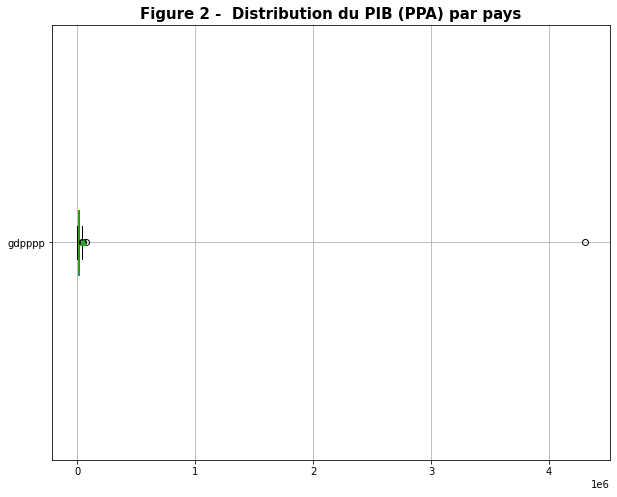

In [39]:
# Distribution des niveaux de PIB PPA par pays
plt.figure(figsize=(10,8))
revenus.groupby('country').mean().boxplot(column='gdpppp', showmeans=True, vert=False)
plt.title('Figure 2 -  Distribution du PIB (PPA) par pays', fontsize=15, fontweight='bold')
plt.savefig('figure/Figure 2 -  Distribution du PIB (PPA) par pays.png', dpi=300)
plt.show()

Le graphique suggère qu'une valeur du PIB PPA est largement supérieure aux autres

In [40]:
revenus.loc[revenus['gdpppp'] > 1000000].head()

,country,year_survey,quantile,nb_quantiles,income,gdpppp
3200,FJI,2008,1,100,308.17334,4300332.0
3201,FJI,2008,2,100,384.33230,4300332.0
3202,FJI,2008,3,100,436.59265,4300332.0
3203,FJI,2008,4,100,486.81436,4300332.0
3204,FJI,2008,5,100,520.19720,4300332.0


Les Fidji auraient donc un PIB PPA de + de 4 millions USD.
D'après la Banque Mondiale, en 2008 les Fidji avaient en réalité un PIB PPA de 7 777,739$.
Il est donc nécessaire de corriger ces données.

In [41]:
# Correction du PIB PPA des Fidji
revenus['gdpppp'].loc[revenus['country'] == 'FJI'] = float(7777.739)

C:\Users\Thibaut\anaconda3\envs\Python\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [42]:
revenus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11600 entries, 0 to 11599
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country       11600 non-null  object 
 1   year_survey   11600 non-null  int64  
 2   quantile      11600 non-null  int64  
 3   nb_quantiles  11600 non-null  int64  
 4   income        11600 non-null  float64
 5   gdpppp        11600 non-null  float64
dtypes: float64(2), int64(3), object(1)
memory usage: 543.9+ KB


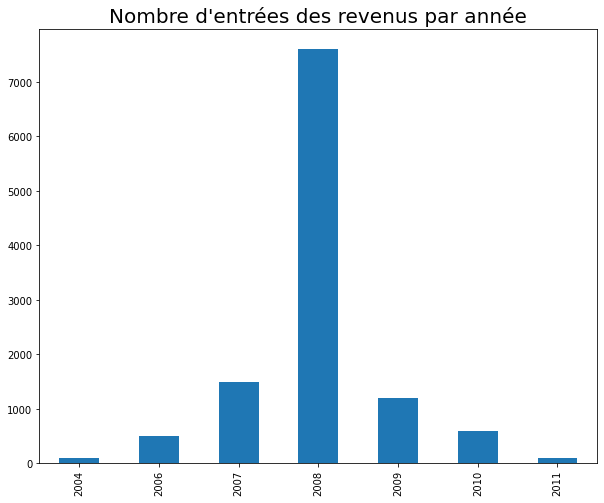

In [43]:
# Graphique en barre quantifiant le nombre d'entrées par année
plt.figure(figsize=(10,8))
revenus['year_survey'].value_counts().sort_index().plot(kind='bar')
plt.title('Nombre d\'entrées des revenus par année', fontsize=20)
plt.savefig('figure/Figure 3 -  Nombre d\'entrées des revenus par année.png', dpi=300)
plt.show()

In [44]:
revenus.year_survey.value_counts()

2008    7600
2007    1500
2009    1200
2010     600
2006     500
2011     100
2004     100
Name: year_survey, dtype: int64

L'année 2008 comptabilise 7600 entrées et la 2e année la mieux renseignée est 2007 avec 1500 entrées.

#### Nettoyage du Dataframe 'Revenus'

In [45]:
# Suppression de la colonne 'year-survey'
revenus.drop(columns=['year_survey'], inplace=True)

In [46]:
# Remplacement de l'intitulé de la colonne 'country' par 'country_code'
revenus = revenus.rename(columns={'gdpppp': 'GDP_ppp'})

L'unité de mesure $ppp correspond à "purchasing power parity", ou parité de pouvoir d'achat en dollars. Cette mesure est utilisée pour comparer les niveaux de revenu réel de divers pays sur la base de la capacité des populations à acheter des biens et des services (PIB et indices des prix).

#### Calcul du coefficient de Gini à partir du Dataframe 'Revenus'

In [47]:
# Fonction du coefficient de Gini
def g(country):
    country = revenus['income'].loc[revenus['country'] == country].values
    lorenz = np.cumsum(np.sort(country) / country.sum())
    lorenz = np.append([0], lorenz)
    xaxis = np.linspace(0,1,len(lorenz))
    area_under_lorenz = np.trapz(y=lorenz, dx=1/len(lorenz))
    area_under_pe = np.trapz(y=xaxis, dx=1/len(lorenz))
    coef_gini = (area_under_pe - area_under_lorenz) / area_under_pe
    return(coef_gini)

In [48]:
# Création d'une colonne dédiée au coefficient de Gini
revenus['Gini'] = [g(i) for i in revenus['country']]

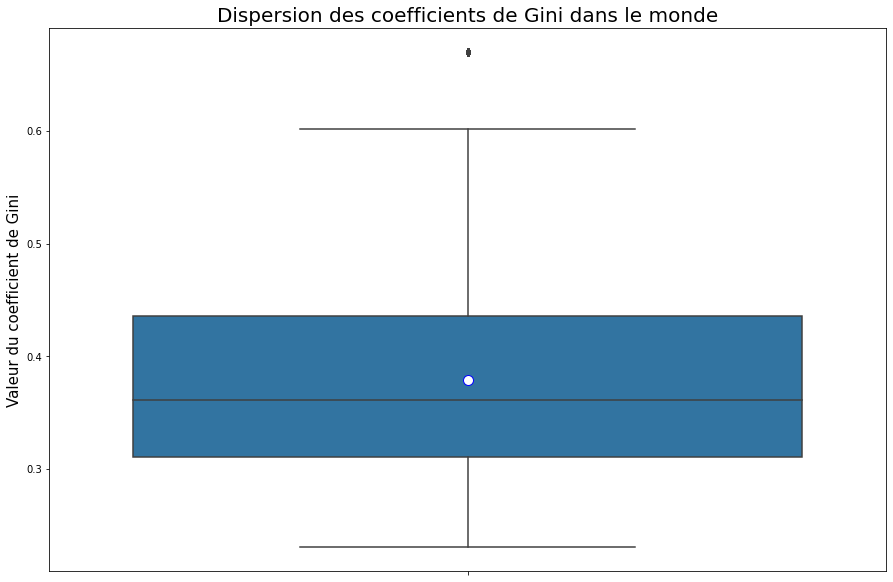

In [49]:
plt.figure(figsize=(15, 10))
sns.boxplot(y="Gini", data = revenus, showmeans=True,
            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"blue",
                       "markersize":"10"})
plt.ylabel("Valeur du coefficient de Gini", size=15)
plt.title("Dispersion des coefficients de Gini dans le monde", size=20)
plt.savefig('figure/Figure 4 -  Dispersion des coefficients de Gini dans le monde.png', dpi=300)
plt.show()

### Jointures

In [50]:
# Préparation du Dataframe 'revenus' à la jointure
revenus = revenus.rename(columns={'country': 'country_code'})

In [51]:
# Jointure des dataframes 'revenus' et 'population')
revenus_pop = pd.merge(revenus, pop, on=['country_code'], how='outer')

In [52]:
# Suppression des 150 entrées du Dataframe 'Population' n'ayant pas de données de revenus
revenus_pop.drop(revenus_pop.loc[revenus_pop['income'].isnull()].index, inplace=True)

In [53]:
# Imputation des données manquantes relatives à Taïwan
revenus_pop['pop_2008'].loc[revenus_pop['country_code'] == 'TWN'] = int(23037000)
revenus_pop['Country Name'].loc[revenus_pop['country_code'] == 'TWN'] = str('Taïwan')

C:\Users\Thibaut\anaconda3\envs\Python\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


#### Calcul de la part de la population mondiale couverte par le dataframe 'Revenus'

In [54]:
# Part de la population couverte par le dataframe 'Revenus'
pop_couverte = revenus_pop.groupby('country_code', as_index=False)['pop_2008'].mean()['pop_2008'].sum()
pop_totale = 6700000000
part_couverte = pop_couverte / pop_totale * 100
print('La population couverte par le dataframe Revenus représente {}% de la population mondiale en 2008'.format(round(part_couverte, 2)))

La population couverte par le dataframe Revenus représente 92.6% de la population mondiale en 2008


#### Ajout du Dataframe de l'Elasticité intergénérationnelle

In [55]:
# Préparation du dataframe 'ige' à la jointure
ige['country_code'] = ige.index

In [56]:
ige.shape

(75, 2)

In [57]:
data = pd.merge(revenus_pop, ige, on=['country_code'], how='outer')

Le Dataframe 'ige_mean' apporte des données à propos de 9 pays (Australie, Bénin, Suisse, Ethiopie, Nouvelle-Zélande, Rwanda, Singapour, Tunisie et Ouzbékistan)  qui n'ont malheureusement pas d'entrées sur le Dataframe 'Revenus'. Nous allons donc supprimer ces 9 pays

In [58]:
# Suppression des 9 pays du Dataframe
data.drop(data.loc[(data['country_code'] == 'AUS') | 
                   (data['country_code'] == 'BEN') | 
                   (data['country_code'] == 'CHE') | 
                   (data['country_code'] == 'ETH') | 
                   (data['country_code'] == 'NZL') | 
                   (data['country_code'] == 'RWA') | 
                   (data['country_code'] == 'SGP') | 
                   (data['country_code'] == 'TUN') | 
                   (data['country_code'] == 'UZB')].index, inplace=True)


In [59]:
# Conversion des valeurs 'quantile' et 'nb_quantiles' en nombres entiers
data['quantile'] = data['quantile'].astype('Int64')
data['nb_quantiles'] = data['nb_quantiles'].astype('Int64')

#### Imputation de la valeur de l'élasticité générationnelle

In [60]:
data.loc[data['IGEincome'].isnull()].shape

(5000, 9)

50 pays n'ont pas d'informations au sujet de leur élasticité intergénérationnelle (EIG). 

D'après le modèle de Gatsby le Magnifique sur la corrélation entre Gini et l'EIG, cette valeur peut être approximativement estimée selon la formule:

EIG = Gini x 2.2 - 0.27

In [61]:
#### selon la formule: IGE = Gini x 2.2 - 0.27
data['IGEincome'].loc[data['IGEincome'].isnull()] = data['Gini'] * 2.2 - 0.27

In [62]:
# Identification des valeurs uniques de l'élasticité
data['IGEincome'].unique()

array([0.8158745 , 0.71978363, 0.30883678, 0.2452668 , 0.4171066 ,
       0.183176  , 0.60472763, 0.538     , 0.52622127, 0.8272523 ,
       0.3427382 , 0.8662677 , 0.635     , 0.5677942 , 0.9658107 ,
       0.26933333, 0.57      , 0.399     , 0.64285199, 0.58659769,
       1.09544   , 0.81357354, 0.342     , 0.434041  , 0.2379042 ,
       0.1451456 , 0.83555277, 1.029957  , 0.9432052 , 0.4237571 ,
       0.39154022, 0.1128757 , 0.6720868 , 0.3571051 , 0.4809783 ,
       0.58820971, 0.561605  , 0.3428547 , 0.3125777 , 1.015206  ,
       1.05366687, 0.4640774 , 0.33312843, 0.54865234, 0.596     ,
       0.2563986 , 0.68562314, 0.52218339, 0.35714718, 0.64127839,
       0.4877371 , 0.5173975 , 0.34      , 0.2379952 , 0.6703727 ,
       0.3528712 , 0.42004246, 0.394     , 0.42184414, 0.50926343,
       0.5679195 , 0.61489088, 0.46596214, 0.3807922 , 0.8899115 ,
       0.9457445 , 0.41512424, 0.6896126 , 0.84757622, 0.4166378 ,
       0.7139534 , 0.36928226, 0.4010016 , 0.73401475, 0.61955

In [63]:
len(data['IGEincome'].unique())

116

In [64]:
# Comparatif du nombre de valeurs si l'élasticité est réduite à 3 chiffres après la virgule
elasticity = data['IGEincome'].round(2).unique()
len(elasticity)

68

In [65]:
# Arrondi à 2 chiffres après la virgule
data['IGEincome'] = data['IGEincome'].round(2)

#### Corrélations

In [66]:
# Matrice de corrélation entre les variables revenus par hab, PIB PPA, coef de Gini, population et EIG
cor = data[['income', 'GDP_ppp', 'Gini', 'pop_2008', 'IGEincome']].corr()
cor

,income,GDP_ppp,Gini,pop_2008,IGEincome
income,1.000000,0.668743,-0.250414,-0.037478,-0.351932
GDP_ppp,0.668743,1.000000,-0.396510,-0.065533,-0.511557
Gini,-0.250414,-0.396510,1.000000,0.085582,0.739587
pop_2008,-0.037478,-0.065533,0.085582,1.000000,-0.023112
IGEincome,-0.351932,-0.511557,0.739587,-0.023112,1.000000


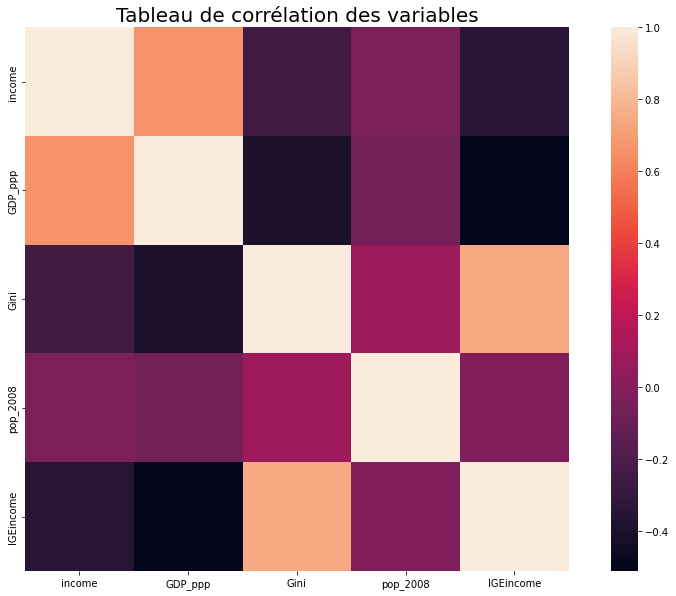

In [67]:
# Tableau de corrélation avec gradients de couleur
plt.figure(figsize=(15, 10))
sns.heatmap(data=cor, square=True)
plt.title("Tableau de corrélation des variables", size=20)
plt.savefig('figure/Figure 5 -  Tableau de corrélation des variables.png', dpi=300)
plt.show()

Le tableau de couleurs montre deux corrélations claires qui s'observent entre les le PIB PPA et le revenu d'une part, et entre le coef de Gini et l'IGE d'autre part. Cette dernière corrélation s'expliquait déjà par la courbe de Gatsby le Magnifique et est ici d'autant plus importante qu'une partie des valeurs imputées de l'IGE a été calculée en fonction du coef de Gini.

# Mission 2: Distribution des revenus selon les pays <a class='anchor' id='deux'></a>

### Classification ascendante hiérarchique et K-moyennes

#### Préparation des données

In [68]:
# Préparation du dataframe pour la CAH sur les variables GDP_ppp, Gini et Population
data_cah = data.groupby('country_code')[['GDP_ppp', 'Gini', 'pop_2008']].agg('mean')

In [69]:
# Conversion de la colonne Population en classe 'float64'
data_cah['pop_2008'] = data_cah['pop_2008'].astype('float64')

In [70]:
data_cah.head()

,GDP_ppp,Gini,pop_2008
country_code,,,
ALB,7297.0,0.304624,2947314.0
ARG,13220.0,0.449902,40080159.0
ARM,5611.0,0.263108,2907615.0
AUT,36193.0,0.278279,8321496.0
AZE,8101.0,0.312321,8763400.0


In [71]:
# Préparation des données pour le clustering
X = data_cah.values
names = data_cah.index
scaler = preprocessing.StandardScaler()

# Centrage et réduction
std_scale = scaler.fit(X)
X_scaled = std_scale.transform(X)

#### Méthode des centres mobiles

In [72]:
# Méthode des centres mobiles par K-means
res = np.arange(9, dtype="double")
for k in np.arange(9):
    km = KMeans(n_clusters=k+2, n_init=10, max_iter = 100, random_state=84)
    km.fit(X_scaled)
    res[k] = metrics.silhouette_score(X_scaled,km.labels_)

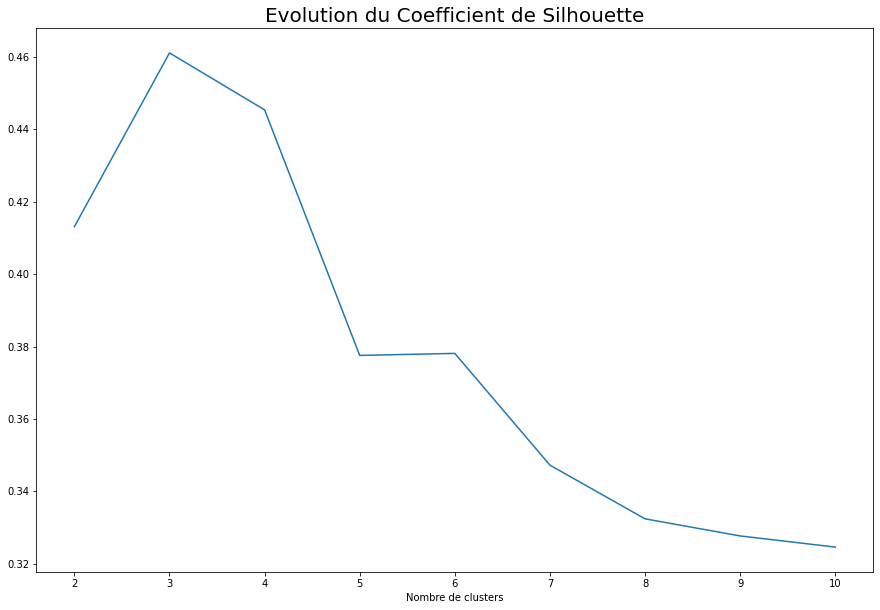

In [73]:
# Graphique
plt.figure(figsize=(15, 10))
plt.xlabel("Nombre de clusters")
plt.plot(np.arange(2,11,1),res)
plt.title("Evolution du Coefficient de Silhouette", size=20)
plt.savefig('figure/Figure 6 -  Evolution du Coefficient de Silhouette.png', dpi=300)
plt.show()

Le nombre de clusters requis se situant entre 5 et 10, la partition en 6 clusters semble la meilleure au sens de la métrique "silhouette"

#### Classification ascendante hiérarchique

In [74]:
# Matrice des liens
Z = linkage(X_scaled, method='ward', metric='euclidean')

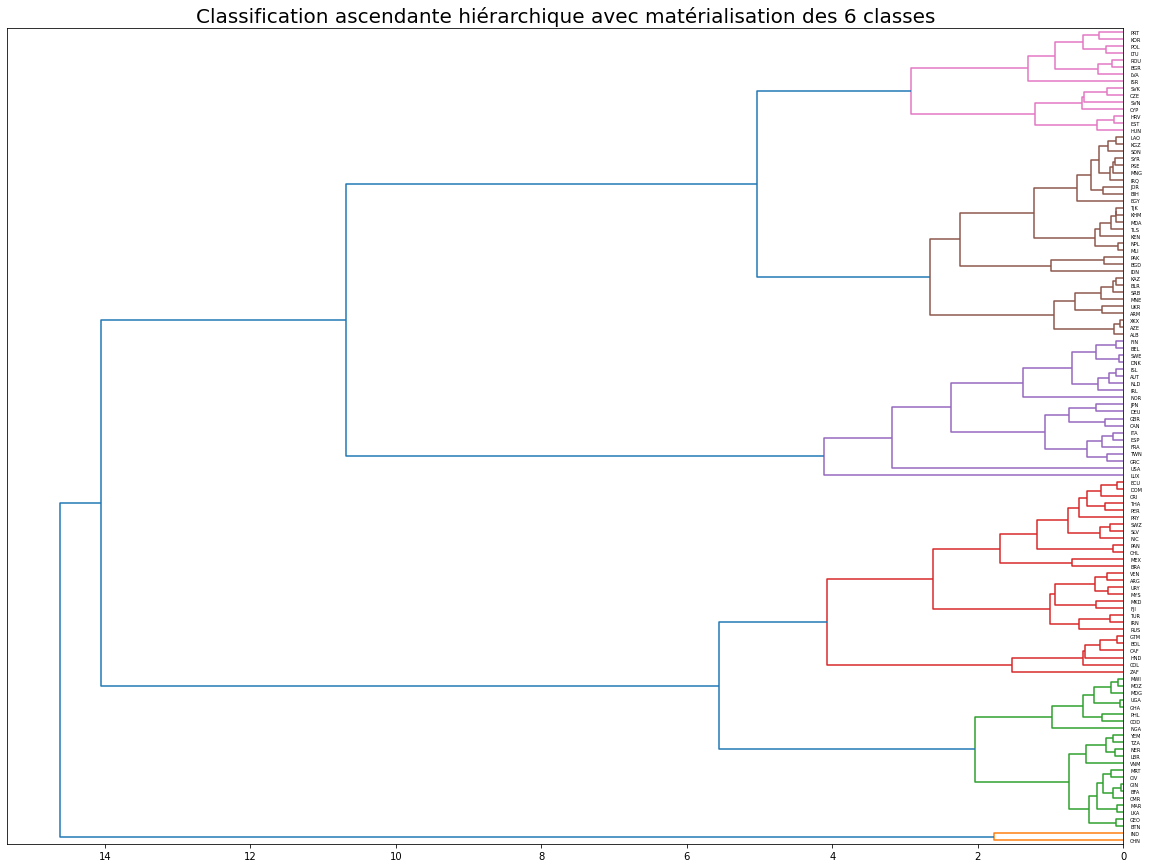

In [75]:
##### Matérialisation des 6 classes (hauteur t = 4.2)
plt.figure(figsize=(20,15))
plt.title("Classification ascendante hiérarchique avec matérialisation des 6 classes", size=20)
dendrogram(Z,labels=names, orientation='left', color_threshold=4.2)
plt.savefig('figure/Figure 7 -  Classification ascendante hiérarchique avec matérialisation des 6 classes.png', dpi=300)
plt.show()

In [76]:
# Découpage à la hauteur t = 4.2
groupes_cah = fcluster(Z,t=4.2, criterion='distance')

# index triés  de groupes_cah
idg = np.argsort(groupes_cah)

# affichage des observations et leurs groupes
clust = pd.DataFrame(data_cah.index[idg], groupes_cah[idg])
clust

,country_code
1,IND
1,CHN
2,CIV
2,GIN
2,YEM
...,...
6,ROU
6,KOR
6,SVN
6,CZE


#### ACP

In [77]:
# Préparation des données pour l'ACP
n_comp = 3
X = data_cah.values
names = data_cah.index
features = data_cah.columns

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca = pca.fit(X_scaled)

In [78]:
pca.explained_variance_ratio_

array([0.47449568, 0.32451603, 0.20098829])

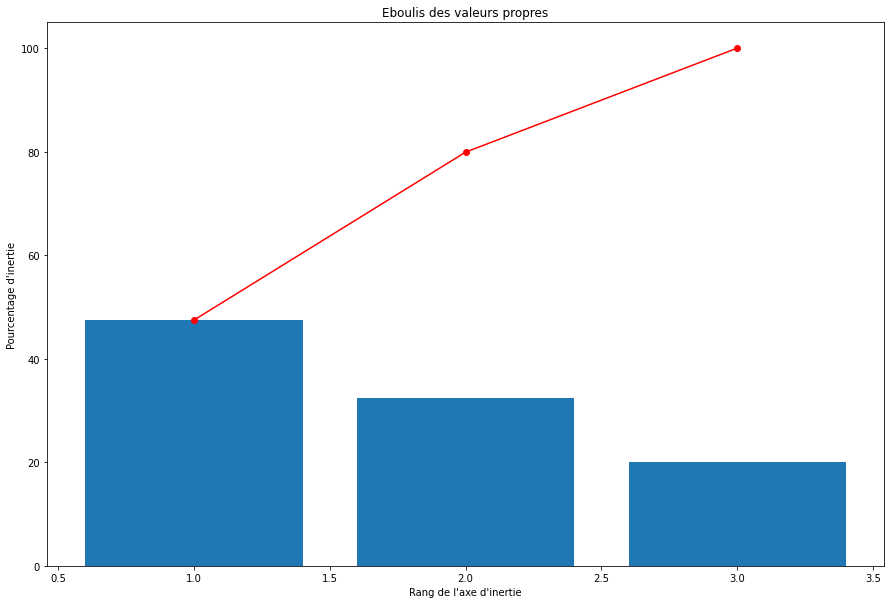

In [79]:
# Eboulis des valeurs propres
def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("Rang de l'axe d'inertie")
    plt.ylabel("Pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")

# Affichage du graphique
plt.figure(figsize=(15,10))
display_scree_plot(pca)
plt.savefig('figure/Figure 8 -  Eboulis des valeurs propres.png', dpi=300)
plt.show()

In [80]:
# Cercle des corrélations
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(10,8))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))
            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

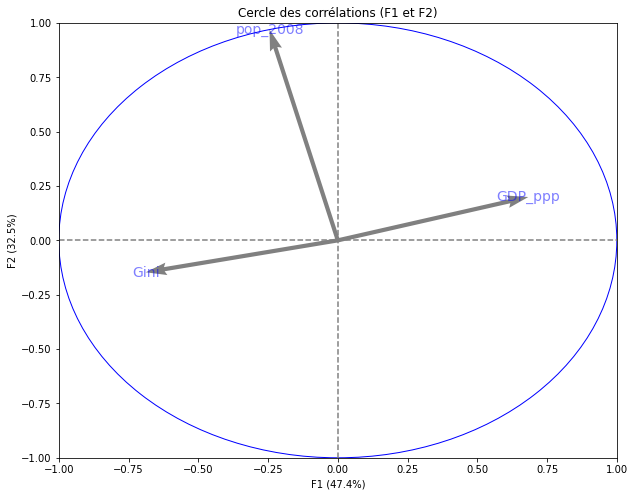

In [81]:
# Projection des variables sur F1 et F2
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1),(2,3),(4,5)], labels = np.array(features))

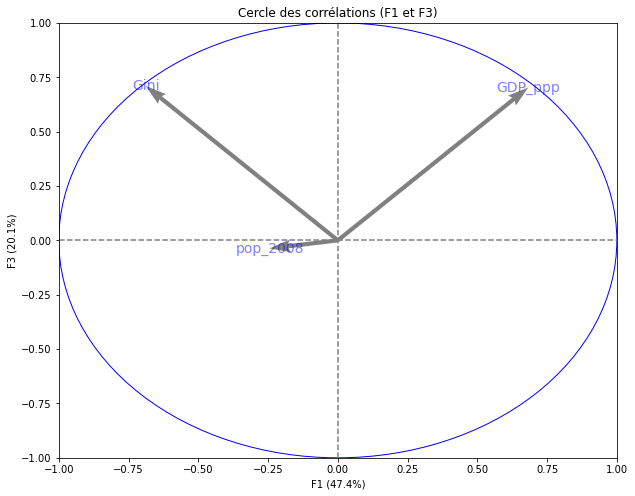

In [82]:
# Projection des variables sur F1 et F3
pcs = pca.components_
display_circles(pcs, n_comp, pca, [[0,2]], labels = np.array(features))

In [83]:
# Fonction de projection des individus dans un plan à deux dimensions
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(10,8))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)


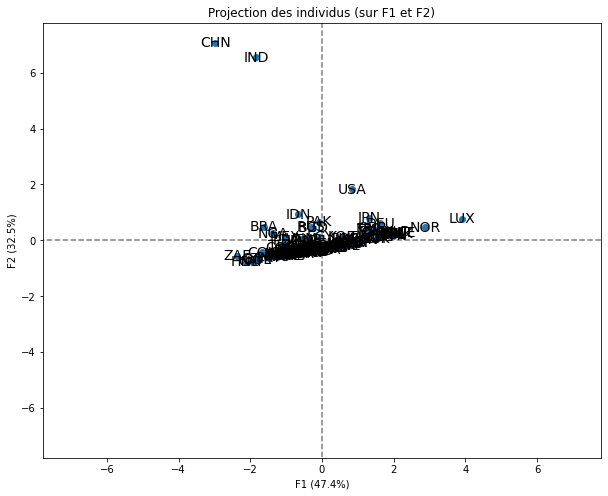

In [84]:
# Projection des individus sur F1 et F2
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0,1)], labels = np.array(names))

plt.show()

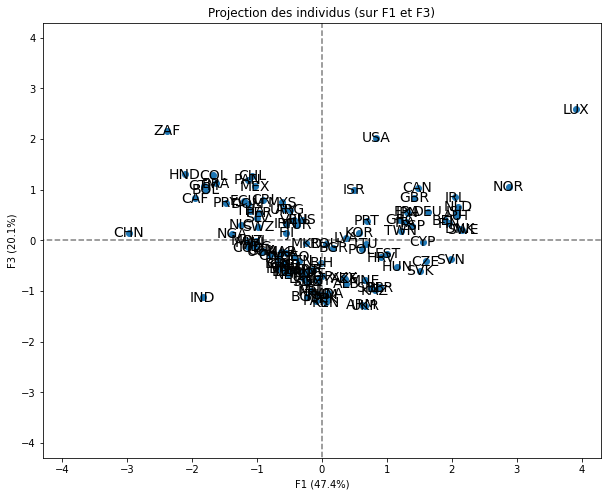

In [85]:
# Projection des individus sur F1 et F3
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0,2)], labels = np.array(names))

plt.show()

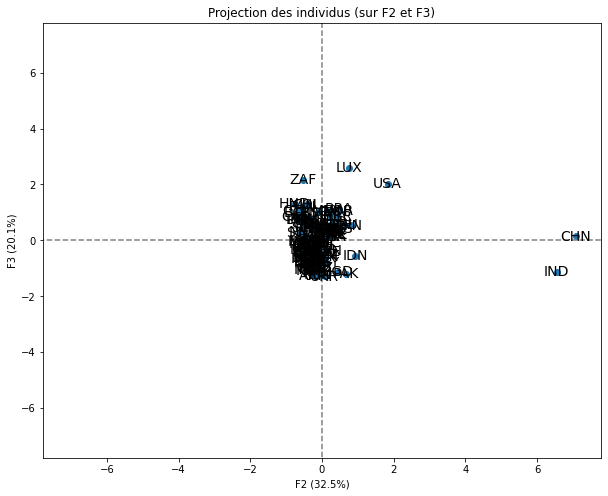

In [86]:
# Projection des individus sur F2 et F3
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(1,2)], labels = np.array(names))

plt.show()

#### Caractérisation des groupes

In [87]:
# Jointure et aggrégation des valeurs par cluster
clust = clust.reset_index()
data_clust = pd.merge(data_cah, clust, on=['country_code'], how='outer')

In [88]:
# Aggrégation par clusters et standardisation des données
Y = data_clust.groupby('index').mean()
Y

,GDP_ppp,Gini,pop_2008
index,,,
1,4254.000000,0.406439,1.262662e+09
2,1928.792022,0.409998,3.195688e+07
3,8599.919250,0.498984,3.506381e+07
4,36276.750000,0.306683,4.390797e+07
5,4708.461871,0.318758,3.250189e+07
6,19429.333333,0.318543,1.153368e+07


In [89]:
# Centrage et réduction des données
scaled_data_clust = scaler.fit_transform(Y)

# Conversion du tableau numpy en Dataframe
scaled_data_clust = pd.DataFrame(scaled_data_clust,
                               index=['1', '2', '3', '4', '5', '6'],
                               columns=['GDP_ppp', 'Gini', 'pop_2008'])

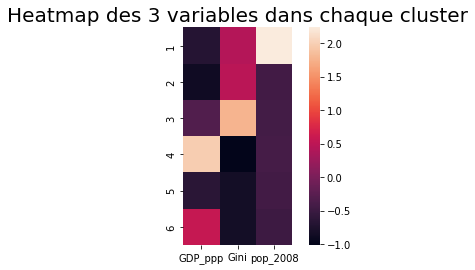

In [90]:
# Affichage des données sous la forme d'une heatmap
sns.heatmap(scaled_data_clust, square=True)
plt.title('Heatmap des 3 variables dans chaque cluster', size=20)
plt.savefig('figure/Figure 14 -  Heatmap des 3 variables dans chaque cluster.png', dpi=300)
plt.show()

Le groupe 1 se distingue par une forte population. 

Le groupe 2 semble avoir un PIB par PPA particulièrement bas.

Le groupe 3 regroupe quant à lui les pays ayant une indice de Gini élevé (fortes inégalités).

Le groupe 4 se constitue de pays dont le PIB par PPA est élevé et l'indice de Gini moyen le plus faible.

Le groupe 5 est composé de pays dont les résultats sont relativement moyens dans chacune des variables.

Le groupe 6 a des pays avec un PIB par PPA relativement élevé, une population assez égalitaire mais avec une démographie plutôt basse.

In [91]:
# Pays du cluster n°1
data_clust.loc[data_clust['index'] == 1]

,country_code,GDP_ppp,Gini,pop_2008,index
17,CHN,5712.0,0.478266,1.324655e+09,1
45,IND,2796.0,0.334613,1.200670e+09,1


In [92]:
gini.loc[gini['country_code'] == 'IND'].isnull().sum(axis=1)

109    56
dtype: int64

In [93]:
gini.loc[gini['country_code'] == 'CHN'].isnull().sum(axis=1)

40    49
dtype: int64

Pour le 1er cluster, nous allons retenirla Chine, qui a un plus grand nombre d'entrées dans le Dataframe "Gini".

In [94]:
# Pays du cluster n°2
data_clust.loc[data_clust['index'] == 2]

,country_code,GDP_ppp,Gini,pop_2008,index
6,BFA,1085.513900,0.397603,14689725.0,2
13,BTN,4525.483051,0.380816,671611.0,2
18,CIV,1526.000000,0.414933,19605568.0,2
19,CMR,2007.000000,0.389363,19252674.0,2
20,COD,303.193050,0.443997,60411195.0,2
36,GEO,4516.000000,0.390095,3848449.0,2
37,GHA,1380.118200,0.427589,23563832.0,2
38,GIN,977.000000,0.396300,9738796.0,2
60,LBR,372.000000,0.380872,3607863.0,2
61,LKA,4202.570300,0.402223,19983984.0,2


Pour le 2e cluster, nous retiendrons la Géorgie.

In [95]:
# Pays du cluster n°3
data_clust.loc[data_clust['index'] == 3]

,country_code,GDP_ppp,Gini,pop_2008,index
1,ARG,13220.000,0.449902,40080159.0,3
11,BOL,3950.000,0.561476,9721457.0,3
12,BRA,9559.000,0.544494,192030362.0,3
14,CAF,685.000,0.561732,4273368.0,3
16,CHL,13390.000,0.531576,16708255.0,3
21,COL,8185.000,0.569271,44254972.0,3
22,CRI,10374.000,0.492533,4463123.0,3
27,DOM,7505.000,0.502524,9458079.0,3
28,ECU,7560.000,0.509880,14535740.0,3
33,FJI,7777.739,0.428221,845356.0,3


Le Pérou représentera le 3e groupe.

In [96]:
# Pays du cluster n°4
data_clust.loc[data_clust['index'] == 4]

,country_code,GDP_ppp,Gini,pop_2008,index
3,AUT,36193.0,0.278279,8321496.0,4
5,BEL,33561.0,0.284595,10709973.0,4
15,CAN,35895.0,0.350219,33247118.0,4
25,DEU,33758.0,0.306465,82110097.0,4
26,DNK,34130.0,0.259871,5493621.0,4
30,ESP,28336.0,0.307419,45954106.0,4
32,FIN,33626.0,0.276857,5313399.0,4
34,FRA,30357.0,0.329096,64374979.0,4
35,GBR,34048.0,0.339382,61806995.0,4
39,GRC,27123.0,0.329403,11077841.0,4


L'Espagne représentera le 4e groupe.

In [97]:
# Pays du cluster n°5
data_clust.loc[data_clust['index'] == 5]

,country_code,GDP_ppp,Gini,pop_2008,index
0,ALB,7297.00000,0.304624,2947314.0,5
2,ARM,5611.00000,0.263108,2907615.0,5
4,AZE,8101.00000,0.312321,8763400.0,5
7,BGD,1233.00000,0.316444,144304164.0,5
9,BIH,7472.00000,0.355548,3754261.0,5
10,BLR,11651.00000,0.266125,9527985.0,5
29,EGY,5011.00000,0.330568,79636081.0,5
44,IDN,3689.00000,0.372115,235469755.0,5
48,IRQ,3171.00000,0.360083,28385739.0,5
52,JOR,5082.93160,0.337725,6556473.0,5


L'Ukraine illustrera le groupe 5.

In [98]:
# Pays du cluster n°6
data_clust.loc[data_clust['index'] == 6]

,country_code,GDP_ppp,Gini,pop_2008,index
8,BGR,11993.0,0.361919,7492561.0,6
23,CYP,26273.0,0.280525,1081568.0,6
24,CZE,23223.0,0.252864,10384603.0,6
31,EST,18773.0,0.300700,1337090.0,6
42,HRV,17219.0,0.302844,4309705.0,6
43,HUN,18004.0,0.274149,10038188.0,6
50,ISR,25740.0,0.414217,7308800.0,6
58,KOR,19162.0,0.351614,49054708.0,6
62,LTU,17571.0,0.334528,3198231.0,6
64,LVA,15596.0,0.362245,2177322.0,6


Enfin, l'Estonie sera le pays représentatif du groupe 6.

In [99]:
# Rassemblement des pays sélectionnés
pays_select = ['CHN','GEO', 'PER', 'ESP', 'UKR', 'EST']

In [100]:
# Rassemblement dans un même dataframe des 7 pays: Inde, Côté d'Ivoire, Pérou, Espagne, Ukraine, Estonie
data_6_pays = data.loc[(data['country_code'] == 'CHN') | (data['country_code'] == 'GEO') | (data['country_code'] == 'PER') | (data['country_code'] == 'ESP') | (data['country_code'] == 'UKR') | (data['country_code'] == 'EST')]

In [101]:
# Construction d'une table pivot regroupant les données de revenus pour chacun des 7 pays
six_pays_pivot = data_6_pays.pivot(index='quantile', columns='Country Name', values='income')

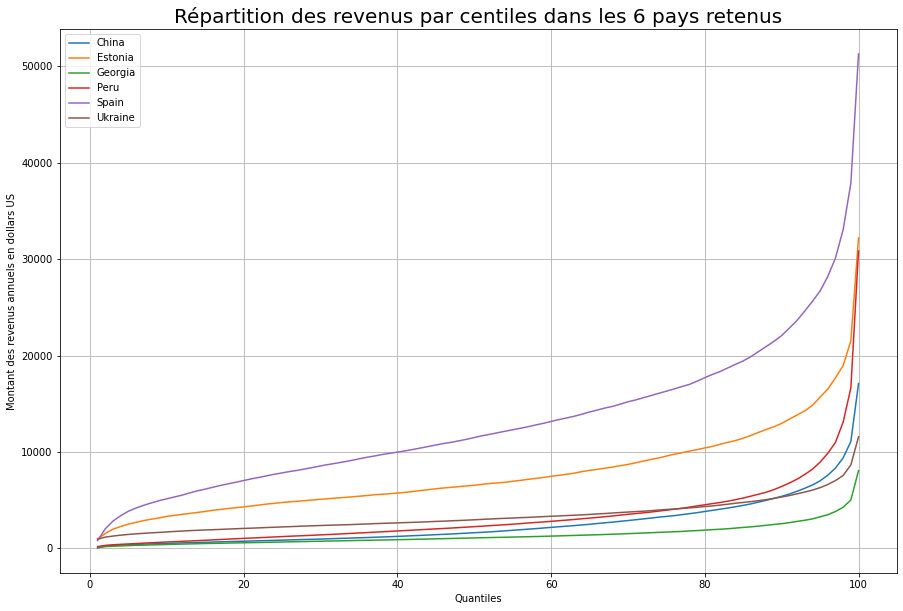

In [102]:
# Répartition des revenus par quantile dans les 6 pays retenus
plt.figure(figsize=(15,10))
plt.title('Répartition des revenus par centiles dans les 6 pays retenus', size=20)
plt.plot(six_pays_pivot)
plt.legend(six_pays_pivot.columns, loc='upper left')
plt.xlabel("Quantiles")
plt.ylabel("Montant des revenus annuels en dollars US")
plt.grid()
plt.savefig('figure/Figure 15 -  Répartition des revenus par centiles dans les 6 pays retenus.png', dpi=300)
plt.show()

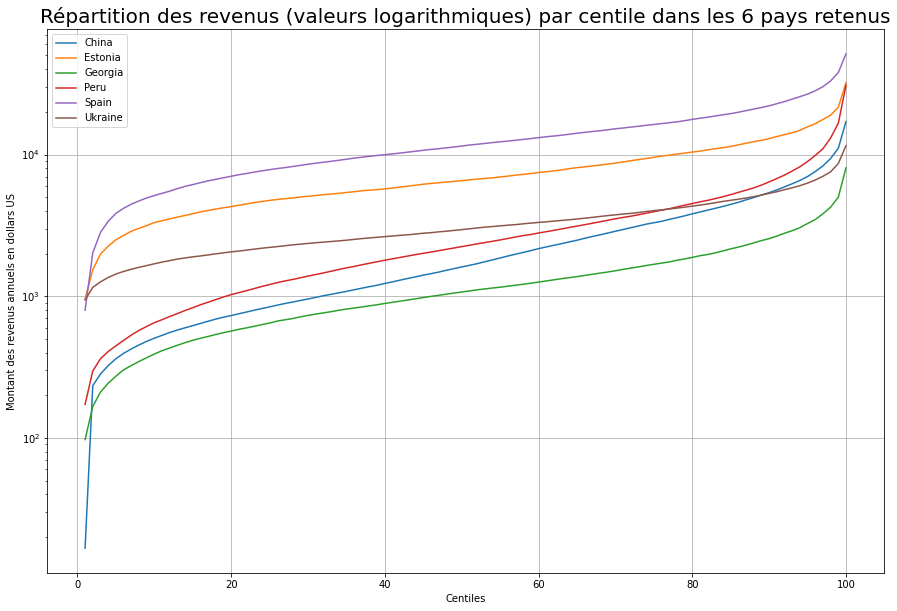

In [103]:
# Répartition des revenus par quantile dans les 6 pays retenus (valeurs logarithmiques)
plt.figure(figsize=(15,10))
plt.title('Répartition des revenus (valeurs logarithmiques) par centile dans les 6 pays retenus', size=20)
plt.plot(six_pays_pivot)
plt.legend(six_pays_pivot.columns, loc='upper left')
plt.xlabel("Centiles")
plt.ylabel("Montant des revenus annuels en dollars US")
plt.yscale('log')
plt.grid()
plt.savefig('figure/Figure 16 -  Répartition des revenus (valeurs logarithmiques) par quantile dans les 6 pays retenus.png', dpi=300)
plt.show()

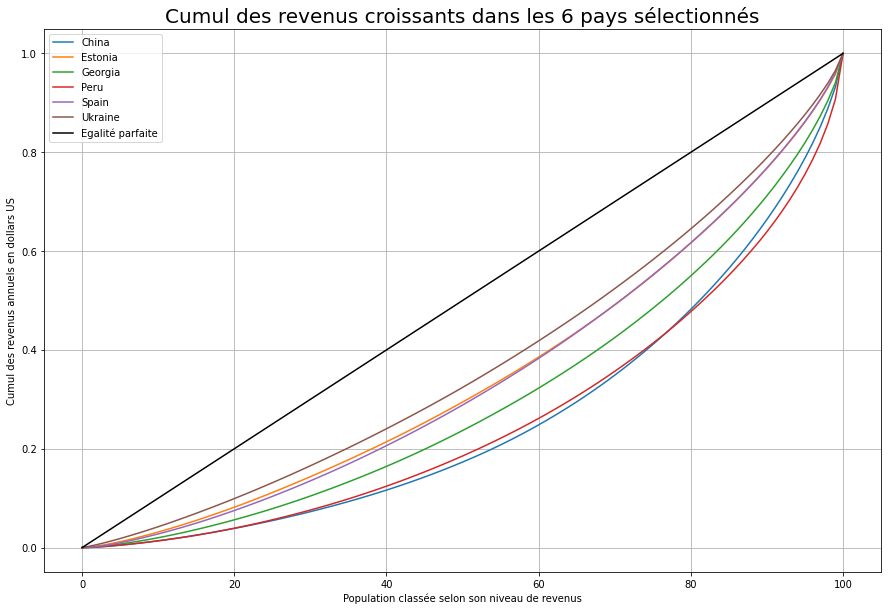

In [104]:
# Graphique représentant le cumul des revenus croissants des 6 pays sélectionnés
plt.figure(figsize=(15,10))
for country in six_pays_pivot.columns:
    lorenz = np.cumsum(six_pays_pivot[country].values / six_pays_pivot[country].values.sum())
    lorenz = np.append([0], lorenz)
    xaxis = np.linspace(0,1,len(lorenz))
    plt.plot(lorenz, label=country)
plt.title("Cumul des revenus croissants dans les 6 pays sélectionnés", size=20)
plt.xlabel("Population classée selon son niveau de revenus")
plt.ylabel("Cumul des revenus annuels en dollars US")
plt.plot([0,100], [0,1], color='k', label="Egalité parfaite")
plt.legend(loc='upper left')
plt.grid()
plt.savefig('figure/Figure 17 -  Cumul des revenus croissants dans les 6 pays sélectionnés.png', dpi=300)
plt.show()

#### Evolution du coefficient de Gini dans les 6 pays sélectionnés

In [105]:
# Projection du dataframe 'Gini' aux 6 pays sélectionnés
gini_six_pays = gini.loc[(gini['country_code'] == 'CHN') | (gini['country_code'] == 'GEO') | (gini['country_code'] == 'PER') | (gini['country_code'] == 'ESP') | (gini['country_code'] == 'UKR') | (gini['country_code'] == 'EST')]

In [106]:
# Suppression des colonnes inutiles et conversion des noms des pays en index
gini_six_pays.drop(columns=['country_code', 'Indicator Name', 'Indicator Code','Unnamed: 65', 'Gini_mean'], inplace=True)
gini_six_pays = gini_six_pays.set_index('Country Name')

C:\Users\Thibaut\anaconda3\envs\Python\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [107]:
# Restriction du dataframe aux années 2000
gini_six_pays_2000 = gini_six_pays.iloc[:,40:59]
gini_six_pays_2000 = gini_six_pays_2000.fillna(method="bfill", axis= 'columns')

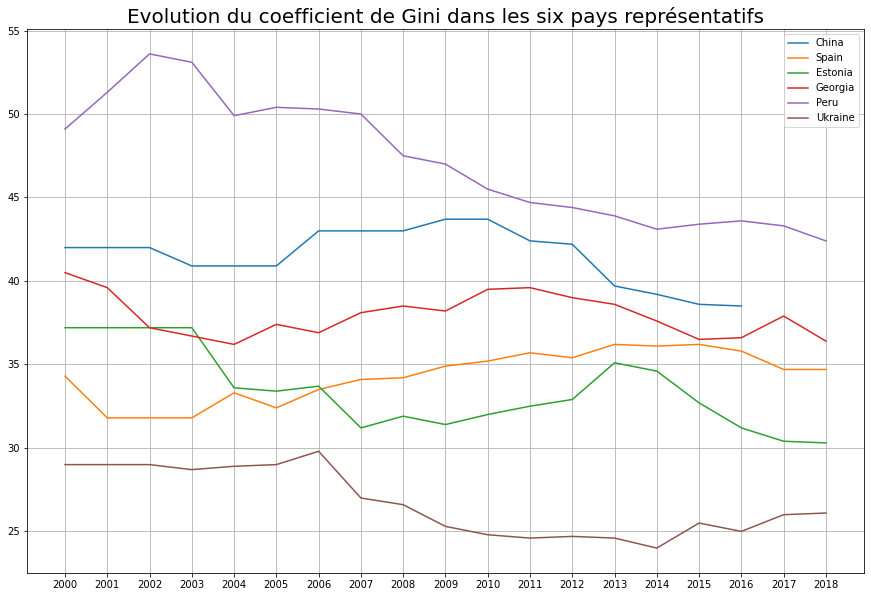

In [108]:
plt.figure(figsize=(15,10))
for country in gini_six_pays_2000.index:
    plt.plot(gini_six_pays_2000.loc[country,:], label=country)
plt.title("Evolution du coefficient de Gini dans les six pays représentatifs", size=20)
plt.legend(loc='upper right')
plt.grid()
plt.savefig('figure/Figure 18 -  Evolution du coefficient de Gini dans les six pays représentatifs.png', dpi=300)
plt.show()

#### Classement des pays selon leur indice de Gini

In [109]:
gini_class = data_cah.sort_values('Gini')
gini_class

,GDP_ppp,Gini,pop_2008
country_code,,,
SVN,27197.0,0.230731,2021316.0
SVK,20515.0,0.247219,5379233.0
CZE,23223.0,0.252864,10384603.0
SWE,34371.0,0.254887,9219637.0
UKR,6721.0,0.255140,46258189.0
...,...,...,...
CAF,685.0,0.561732,4273368.0
GTM,4367.0,0.568293,13739299.0
COL,8185.0,0.569271,44254972.0


Les 5 pays ayant les taux de Gini les plus bas sont dans l'ordre: la Slovénie, la Slovaquie, la République Tchèque, la Suède et l'Ukraine.
Les 5 pays ayant les taux de Gini les plus élevés sont dans l'ordre: l'Afrique du Sud, le Honduras, la Colombie, le Guatemala et la République Centrafricaine

In [110]:
# Ajout d'un index qui indiquera le rang de chaque pays
gini_class['country_code'] = gini_class.index
gini_class.reset_index(drop=True, inplace=True)

In [111]:
# Positionnement de la France
gini_class.loc[gini_class['country_code'] == 'FRA']

,GDP_ppp,Gini,pop_2008,country_code
39,30357.0,0.329096,64374979.0,FRA


En 2008, la France était le pays ayant le 39e plus faible indice de Gini.

In [112]:
gini_class['Gini'].mean()

0.3789671029148795

La moyenne du coefficient de Gini parmi les pays de notre jeu de données était de 0.38 en 2008.

#### Évolution du coefficient de Gini de 10 pays

In [113]:
# Restriction aux 10 pays ayant soit le plus haut soit le plus coefficient de Gini en 2008
gini_evo = gini.loc[(gini['country_code'] == 'SVN') | 
                    (gini['country_code'] == 'SVK') | 
                    (gini['country_code'] == 'CZE') | 
                    (gini['country_code'] == 'SWE') | 
                    (gini['country_code'] == 'UKR') | 
                    (gini['country_code'] == 'CAF') | 
                    (gini['country_code'] == 'GTM') | 
                    (gini['country_code'] == 'COL') | 
                    (gini['country_code'] == 'HND') | 
                    (gini['country_code'] == 'ZAF')]

In [114]:
# Nettoyage du dataframe
gini_evo.drop(columns=['country_code', 'Indicator Name', 'Indicator Code','Unnamed: 65', 'Gini_mean'], inplace=True)
gini_evo = gini_evo.set_index('Country Name')

C:\Users\Thibaut\anaconda3\envs\Python\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [115]:
# Restriction du dataframe aux années suivant 1990
gini_evo = gini_evo.iloc[:,20:59]
gini_evo = gini_evo.fillna(method="bfill", axis= 'columns')

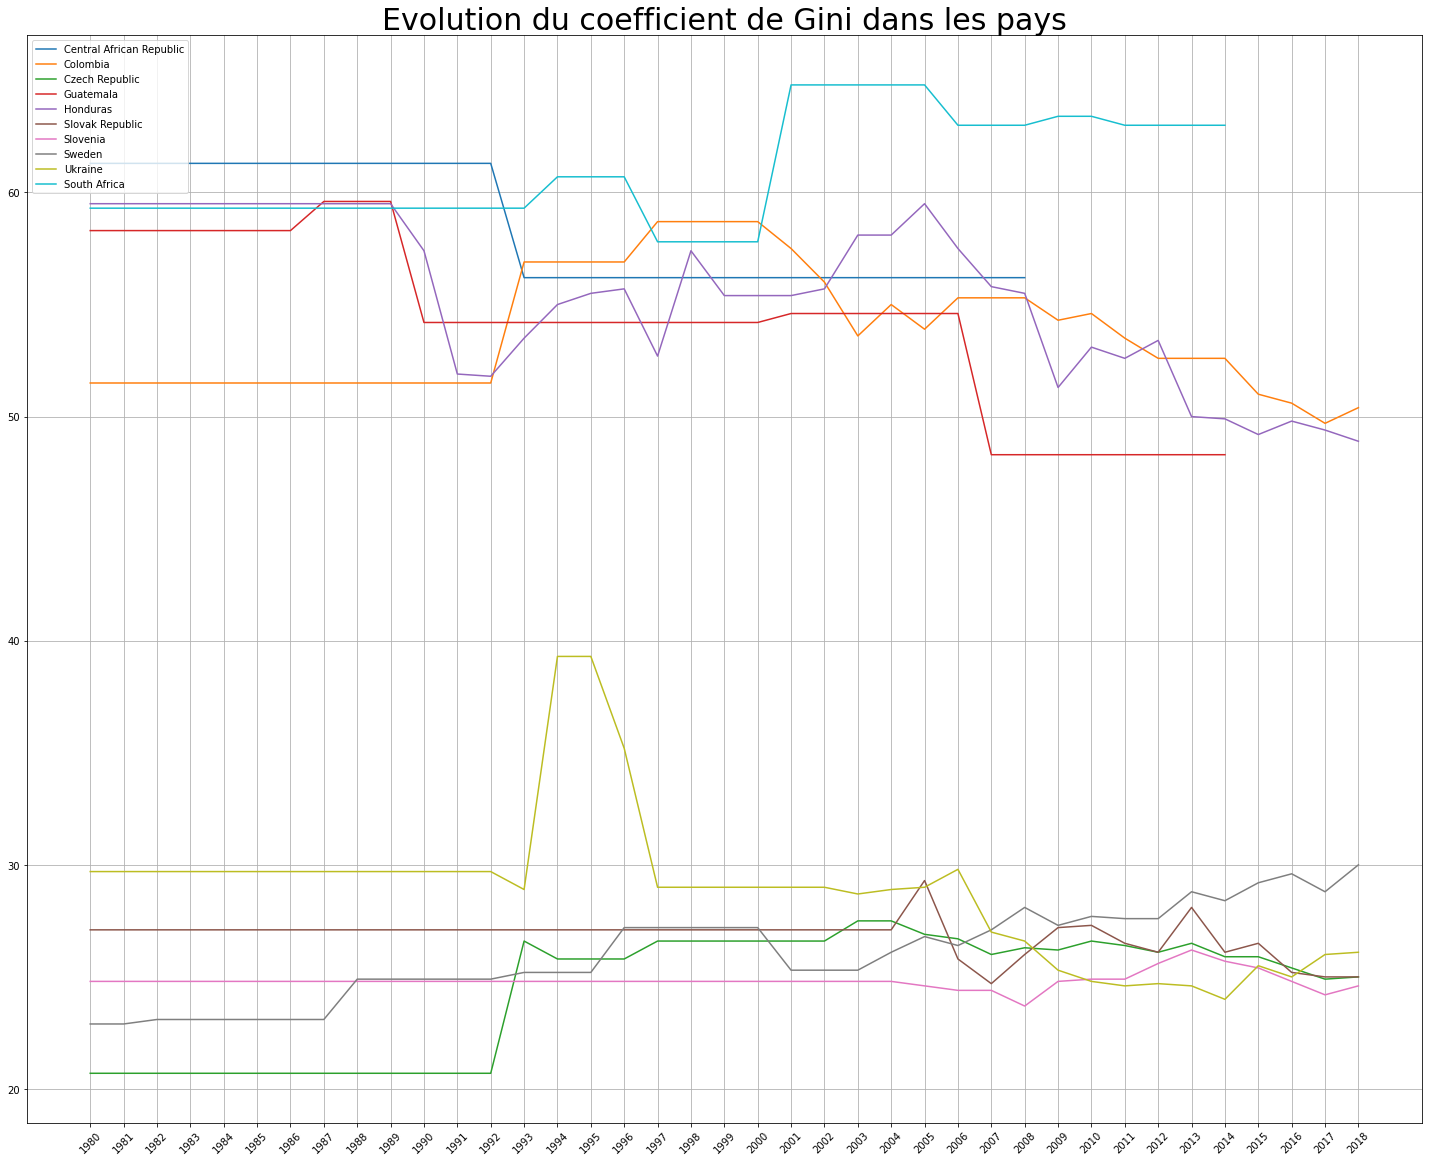

In [116]:
# Evolution du coef de Gini
plt.figure(figsize=(25,20))
for country in gini_evo.index:
    plt.plot(gini_evo.loc[country,:], label=country)
plt.title("Evolution du coefficient de Gini dans les pays", size=30)
plt.legend(loc='upper left')
plt.xticks(rotation=45)
plt.grid()
plt.savefig('figure/Figure 19 -  Evolution du coefficient de Gini dans les pays.png', dpi=300)
plt.show()

#### Identification des pays ayant connu les plus grands écarts dans l'évolution du coefficient de Gini

In [117]:
gini_gap = gini.copy()
gini_gap.drop(columns=['country_code', 'Indicator Name', 'Indicator Code','Unnamed: 65', 'Gini_mean'], inplace=True)
gini_gap = gini_gap.set_index('Country Name')

In [118]:
gini_gap['max_gini'] = gini_gap.max(axis=1)
gini_gap['min_gini'] = gini_gap.min(axis=1)

In [119]:
gini_gap['highest_gap'] = gini_gap['max_gini'] - gini_gap['min_gini']
gini_gap.sort_values('highest_gap', ascending=False).head(10)

,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,...,2014,2015,2016,2017,2018,2019,2020,max_gini,min_gini,highest_gap
Country Name,,,,,,,,,,,,,,,,,,,,,
Malawi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,44.7,NaN,NaN,NaN,NaN,65.8,39.9,25.9
Sao Tome and Principe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,56.3,NaN,NaN,NaN,56.3,30.8,25.5
Bolivia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,47.8,46.7,45.3,44.6,42.6,41.6,NaN,61.6,41.6,20.0
Zambia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,57.1,NaN,NaN,NaN,NaN,NaN,60.5,42.1,18.4
Lesotho,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,44.9,NaN,NaN,NaN,63.2,44.9,18.3
Mauritania,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,32.6,NaN,NaN,NaN,NaN,NaN,NaN,50.1,32.6,17.5
Paraguay,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,50.7,47.6,47.9,48.5,46.0,45.7,NaN,58.2,40.8,17.4
Costa Rica,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.6,48.4,48.7,48.3,48.0,48.2,NaN,51.8,34.4,17.4
Mali,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.4,33.0,17.4


Les pays ayant connu les plus fortes variations de leur coefficient de Gini depuis 1960 sont: le Malawi, Sao Tome, la Bolivie, la Zambie, le Lesotho, la Mauritanie, le Paraguay, le Costa Rica, le Mali et la Moldavie.

L'écart entre les valeurs maximales et minimales du coefficient de Gini montre que les pays ayant connu les plus fortes augmentations du coefficient de Gini sont des pays en développement ayant oscillé ces dernières décennies entre des périodes de paix et de conflits.

# Mission 3: Distributions conditionnelles <a class='anchor' id='trois'></a>

### Question 1 à 7: Génération des probabilités conditionnelles

In [120]:
def generate_incomes(n, pj):
    # On génère les revenus des parents (exprimés en logs) selon une loi normale
    # La moyenne et variance n'ont aucune incidence sur le résultat final (ie. sur le caclul de la classe de revenu)
    # st.norm() donne une variable continu de loi normale
    
    # Question 1: Génération de n réalisations d'une variable ln(Y_parent) selon une loi normale
    # .rvs() donne une variable aléatoire d'un type donné
    ln_y_parent = st.norm(0,1).rvs(size=n)
    # Question 2: Génération d'une réalisation du terme d'erreur epsilon selon une
    # loi normale de moyenne 0 et d'écart-type 1
    residues = st.norm(0,1).rvs(size=n)
    # Question 3: Valeur de y_parent et y_child
    # np.exp donne la valeur expononentielle
    return np.exp(pj*ln_y_parent + residues), np.exp(ln_y_parent)

def quantiles(l, nb_quantiles):
    size = len(l)
    l_sorted = l.copy()
    l_sorted = l_sorted.sort_values()
    # np.arange(début, fin, écart)
    quantiles = np.round(np.arange(1, nb_quantiles+1, nb_quantiles/size) -0.5 +1./size)
    # zip retourne les correspondances entre les éléments d'une liste selon leur positionnement
    q_dict = {a:int(b) for a,b in zip(l_sorted,quantiles)} 
    return pd.Series([q_dict[e] for e in l])

# Question 4: Calcul de la classe de revenu c_i_child et c_i_parents
# compute_quantile: retourne un dataframe présentant pour chaque enfant son 
# revenu, celui de ses parents, sa classe de revenus et celle de ses parents
def compute_quantiles(y_child, y_parents, nb_quantiles):
    y_child = pd.Series(y_child)
    y_parents = pd.Series(y_parents)
    c_i_child = quantiles(y_child, nb_quantiles)
    c_i_parent = quantiles(y_parents, nb_quantiles)
    sample = pd.concat([y_child, y_parents, c_i_child, c_i_parent], axis=1)
    sample.columns = ["y_child", "y_parents", "c_i_child","c_i_parent"]
    return sample

def distribution(counts, nb_quantiles):
    distrib = []
    total = counts["counts"].sum()

    if total == 0 :
        return [0] * nb_quantiles
    
    for q_p in range(1, nb_quantiles+1):
        subset = counts[counts.c_i_parent == q_p]
        if len(subset):    
            nb = subset["counts"].values[0]
            distrib += [nb / total]
        else:
            distrib += [0]
    return distrib   

# Question 5: calcul de la matrice de distribution conditionnelle de 
# c_i_parents pour chaque c_i_child
def conditional_distributions(sample, nb_quantiles):
    # pour chaque classe de revenu d'un enfant c_i_child, on compte le nombre
    # de parents par classe de revenu c_i_parent
    counts = sample.groupby(["c_i_child","c_i_parent"]).apply(len)
    counts = counts.reset_index()
    counts.columns = ["c_i_child","c_i_parent","counts"]
    # calcul de la matrice de distribution conditionnelle de c_i_parent pour 
    # chaque classe de revenu c_i_child
    mat = []
    for child_quantile in np.arange(nb_quantiles)+1:
        subset = counts[counts.c_i_child == child_quantile]
        mat += [distribution(subset, nb_quantiles)]
    return np.array(mat) 

# Affichage graphique de la matrice de distribution conditionnelle
def plot_conditional_distributions(p, cd, nb_quantiles):
    plt.figure(figsize=(15,10))
    
    # La ligne suivante sert à afficher un graphique en "stack bars", 
    # sur ce modèle : https://matplotlib.org/gallery/lines_bars_and_markers/bar_stacked.html
    cumul = np.array([0] * nb_quantiles)
    
    for i, child_quantile in enumerate(cd):
        plt.bar(np.arange(nb_quantiles)+1, child_quantile, bottom=cumul, width=0.95, label = str(i+1) +"e")
        cumul = cumul + np.array(child_quantile)

    plt.axis([.5, nb_quantiles*1.3 ,0 ,1])
    plt.legend(fontsize=25)
    plt.title("Distributions conditionnelles: p=" + str(round(p,2)), fontsize=30, fontweight='bold')
    plt.xlabel("quantile parents", fontsize=20,fontweight = 'bold')
    plt.ylabel("probabilité du quantile enfant", fontsize=20,fontweight = 'bold')
    plt.xticks(fontsize=25)
    plt.yticks(fontsize=25)
    plt.show()

# Selon la classe de l'enfant et le coefficient d'élasticité du pays,
#  probabilité d'appartenance d'un parent à une classe 
def proba_cond(c_i_parent, c_i_child, mat):
    return mat[c_i_child-1, c_i_parent-1]


#### Mobilité intergénérationnelle dans un pays à faible élasticité

In [121]:
pj = 0.9                 # coefficient d'élasticité du pays j
nb_quantiles = 10        # nombre de quantiles (nombre de classes de revenu)
n  = 1000*nb_quantiles   # taille de l'échantillon


In [122]:
y_child, y_parents = generate_incomes(n, pj)
sample = compute_quantiles(y_child, y_parents, nb_quantiles)
cd = conditional_distributions(sample, nb_quantiles)
print(cd)

[[0.459 0.205 0.129 0.091 0.057 0.027 0.018 0.007 0.003 0.004]
 [0.21  0.223 0.175 0.121 0.102 0.076 0.042 0.031 0.015 0.005]
 [0.132 0.181 0.151 0.142 0.118 0.093 0.077 0.053 0.037 0.016]
 [0.083 0.113 0.145 0.148 0.131 0.125 0.108 0.07  0.057 0.02 ]
 [0.033 0.106 0.122 0.14  0.136 0.121 0.128 0.107 0.071 0.036]
 [0.049 0.074 0.114 0.118 0.133 0.121 0.13  0.122 0.097 0.042]
 [0.016 0.044 0.065 0.091 0.133 0.147 0.141 0.129 0.144 0.09 ]
 [0.011 0.036 0.055 0.07  0.076 0.132 0.152 0.18  0.156 0.132]
 [0.007 0.013 0.034 0.054 0.081 0.111 0.121 0.168 0.198 0.213]
 [0.    0.005 0.01  0.025 0.033 0.047 0.083 0.133 0.222 0.442]]


In [214]:
data.loc[data.country_code == 'FRA']

,country_code,quantile,nb_quantiles,income,GDP_ppp,Gini,Country Name,pop_2008,IGEincome
3300,FRA,1.0,100,2958.3040,30357.0,0.329096,France,64374979,0.36
3301,FRA,2.0,100,4412.6753,30357.0,0.329096,France,64374979,0.36
3302,FRA,3.0,100,4939.6350,30357.0,0.329096,France,64374979,0.36
3303,FRA,4.0,100,5422.9165,30357.0,0.329096,France,64374979,0.36
3304,FRA,5.0,100,5906.5376,30357.0,0.329096,France,64374979,0.36
...,...,...,...,...,...,...,...,...,...
3395,FRA,96.0,100,39873.5100,30357.0,0.329096,France,64374979,0.36
3396,FRA,97.0,100,43693.0350,30357.0,0.329096,France,64374979,0.36
3397,FRA,98.0,100,49489.5820,30357.0,0.329096,France,64374979,0.36
3398,FRA,99.0,100,60758.6130,30357.0,0.329096,France,64374979,0.36


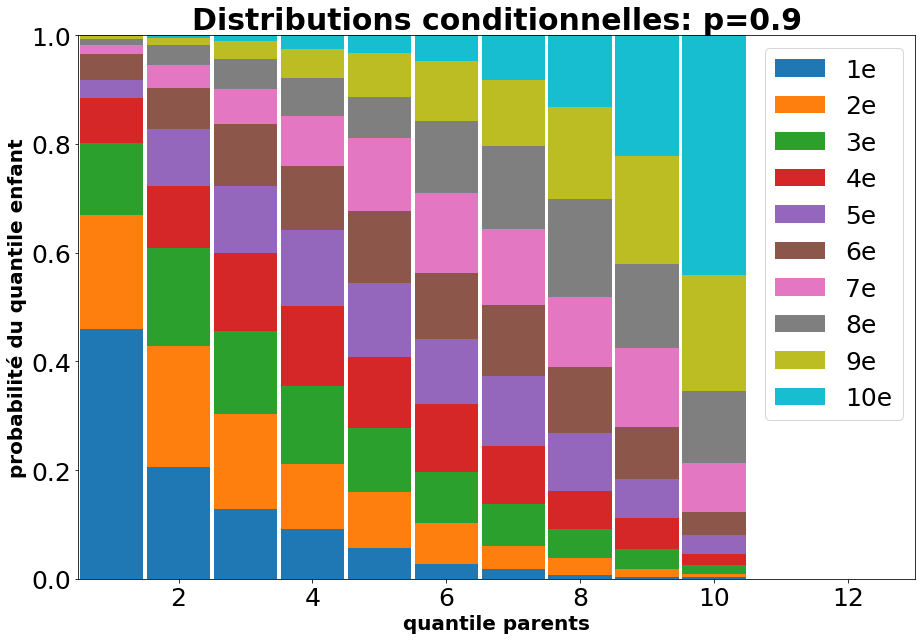

In [123]:
# Représentation graphique
plot_conditional_distributions(pj, cd, nb_quantiles)

In [124]:
c_i_child = 9
c_i_parent = 3
p = proba_cond(c_i_parent, c_i_child, cd)
print("\nP(c_i_parent = {} | c_i_child = {}, pj = {}) = {}".format(c_i_parent, c_i_child, pj, p))



P(c_i_parent = 3 | c_i_child = 9, pj = 0.9) = 0.034


Dans un pays dont l'élasticité intergénérationnelle s'élève à 0.9, les enfants dont les parents appartiennent au 3e décile ont 3.3% de chance d'appartenir au 9e décile.

#### Mobilité intergénérationnelle dans un pays à forte élasticité

In [125]:
pj = 0.1
nb_quantiles = 10
n = 1000 * nb_quantiles
y_child, y_parents = generate_incomes(n,pj)
sample = compute_quantiles(y_child, y_parents, nb_quantiles)
cd = conditional_distributions(sample, nb_quantiles)
print(cd)

[[0.137 0.11  0.108 0.098 0.109 0.101 0.092 0.076 0.085 0.084]
 [0.122 0.11  0.103 0.09  0.101 0.103 0.102 0.09  0.094 0.085]
 [0.117 0.102 0.11  0.108 0.117 0.089 0.098 0.096 0.075 0.088]
 [0.107 0.098 0.096 0.129 0.097 0.103 0.084 0.106 0.081 0.099]
 [0.101 0.112 0.104 0.101 0.086 0.109 0.104 0.106 0.092 0.085]
 [0.097 0.084 0.102 0.11  0.096 0.089 0.106 0.109 0.103 0.104]
 [0.084 0.11  0.116 0.089 0.09  0.094 0.115 0.092 0.107 0.103]
 [0.084 0.107 0.094 0.091 0.102 0.097 0.095 0.091 0.123 0.116]
 [0.084 0.086 0.081 0.094 0.097 0.108 0.092 0.121 0.12  0.117]
 [0.067 0.081 0.086 0.09  0.105 0.107 0.112 0.113 0.12  0.119]]


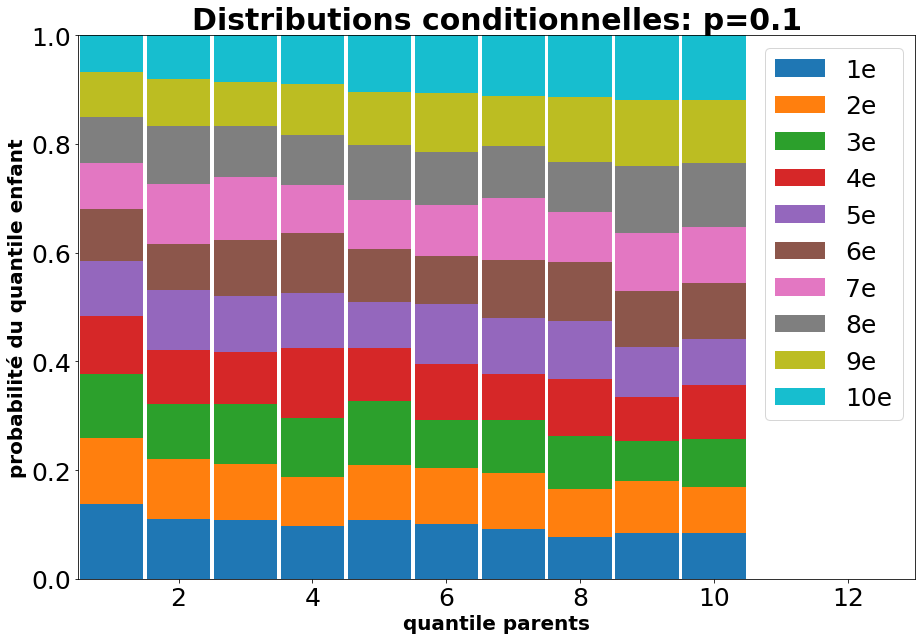

In [126]:
plot_conditional_distributions(pj, cd, nb_quantiles)

In [127]:
c_i_child = 9
c_i_parent = 3
p = proba_cond(c_i_parent, c_i_child, cd)
print("\nP(c_i_parent = {} | c_i_child = {}, pj = {}) = {}".format(c_i_parent, c_i_child, pj, p))



P(c_i_parent = 3 | c_i_child = 9, pj = 0.1) = 0.081


Dans un pays dont l'élasticité intergénérationnelle s'élève à 0.1, les enfants dont les parents appartiennent au 3e décile de revenus ont 8.9% de chances de voir leurs revenus se hisser au 9e décile.

#### Génération des probabilités conditionelles

In [128]:
np.arange(0,101,3)

array([ 0,  3,  6,  9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48,
       51, 54, 57, 60, 63, 66, 69, 72, 75, 78, 81, 84, 87, 90, 93, 96, 99])

In [129]:
# Création d'un dataframe 1-1, 1-2, 1-3 to 100-99, 100-99, 100-100
prob_cond_selection = pd.DataFrame()
prob_cond_selection["classe_enfant"] = np.arange(1,101)
prob_cond_selection["classe_parent"] = np.arange(1,101)
prob_cond_selection_repeat = pd.concat([prob_cond_selection]*100, ignore_index=True)
A = prob_cond_selection_repeat["classe_parent"].values
prob_cond_selection_repeat.set_index(['classe_enfant', 'classe_parent'], inplace=True)
prob_cond_selection_repeat.sort_index(inplace = True)
prob_cond_selection_repeat.reset_index(inplace=True)
prob_cond_selection_repeat["classe_parent"] = A
prob_cond_selection_repeat.set_index(['classe_enfant', 'classe_parent'], inplace=True)
prob_cond_selection_repeat.head()

Empty DataFrame
Columns: []
Index: [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5)]

In [130]:
# Vérification de la taille de l'index, dont le total doit être égal à 100x100
prob_cond_selection_repeat.shape

(10000, 0)

In [131]:
# Vérification de l'existence du fichier
check = os.path.exists("data\\prob_cond.csv")
check

True

In [132]:
# Envion 9 minutes de calcul
# Vérification de la condition
if check == False : 
    # Début du timer
    start = time.time()
    prob_cond = prob_cond_selection_repeat.copy()
    for coef in elasticity :
        clear_output(" ")
        pj=coef
        nb_quantiles = 100
        n  = 1000*nb_quantiles
        y_child, y_parents = generate_incomes(n, pj)
        sample = compute_quantiles(y_child, y_parents, nb_quantiles)
        cd = conditional_distributions(sample, nb_quantiles)
        # Passage de la matrice à 1 dimension
        cd_flat = cd.flatten()
        prob_cond[pj] = cd_flat
        # Affichage du progrès
        print( len(prob_cond.columns) - len(elasticity))
    # Sauvegarde du fichier csv
    prob_cond.to_csv("data\\prob_cond.csv", index = True)
    # Fin du timer
    end = time.time()
    clear_output()
    print( "Calcul réalisé en %.2f secondes" % (end - start) )

In [133]:
# Lecture du fichier csv et nettoyage rapide
prob_cond = pd.read_csv("data\\prob_cond.csv")
prob_cond.set_index(['classe_enfant', 'classe_parent'], inplace=True)
prob_cond.columns = prob_cond.columns.astype("float")
prob_cond.head()

0.82   0.72   0.31   0.25   0.42   0.18   0.60  \
classe_enfant classe_parent                                                    
1             1              0.201  0.176  0.067  0.043  0.084  0.026  0.142   
              2              0.113  0.092  0.035  0.032  0.046  0.029  0.094   
              3              0.076  0.060  0.033  0.019  0.047  0.023  0.048   
              4              0.065  0.044  0.037  0.032  0.047  0.023  0.051   
              5              0.062  0.049  0.025  0.016  0.033  0.023  0.042   

                              0.54   0.53   0.83  ...   0.20   0.44   0.45  \
classe_enfant classe_parent                       ...                        
1             1              0.117  0.105  0.205  ...  0.040  0.076  0.099   
              2              0.069  0.070  0.115  ...  0.031  0.064  0.039   
              3              0.057  0.056  0.078  ...  0.025  0.050  0.050   
              4              0.040  0.054  0.057  ...  0.023  0.035  0.043   
              5              0.045  0.041  0.067  ...  0.018  0.041  0.046   

                              0.70   0.28   0.77   0.75   0.80   0.29   0.68  
classe_enfant classe_parent                                                   
1             1              0.164  0.048  0.191  0.190  0.210  0.061  0.172  
              2              0.104  0.040  0.097  0.097  0.122  0.031  0.076  
              3              0.085  0.035  0.069  0.080  0.073  0.039  0.076  
              4              0.053  0.023  0.053  0.059  0.059  0.037  0.066  
              5              0.056  0.028  0.053  0.050  0.050  0.025  0.061  

[5 rows x 67 columns]

In [134]:
prob_cond.shape

(10000, 67)

In [135]:
# Exemple de récupération d'une probabilité de la distribution conditionnelle
pays = "FRA"
c_i_child = 73
c_i_parent = 34

pj = data["IGEincome"].loc[data["country_code"] == pays].unique().round(2)
p = prob_cond.loc[(c_i_child, c_i_parent), pj].values
print("P(c_i_parent = {} | c_i_child = {}, pj = {}) = {}".format(c_i_parent, c_i_child, pj, p))

P(c_i_parent = 34 | c_i_child = 73, pj = [0.36]) = [0.005]


En France où l'élasticité intergénérationnelle s'élève à 0.36, les enfants dont les parents appartiennent au centile 34 ont 0.5% de chances d'appartenir au centile 73.

#### Intégration des probabilités conditionnelles

In [136]:
#Préparation du dataframe
data_repeat = data.copy()
data_repeat = pd.concat([data]*100, ignore_index=True)
data_repeat.head()

,country_code,quantile,nb_quantiles,income,GDP_ppp,Gini,Country Name,pop_2008,IGEincome
0,ALB,1,100,728.89795,7297.0,0.304624,Albania,2947314,0.82
1,ALB,2,100,916.66235,7297.0,0.304624,Albania,2947314,0.82
2,ALB,3,100,1010.91600,7297.0,0.304624,Albania,2947314,0.82
3,ALB,4,100,1086.90780,7297.0,0.304624,Albania,2947314,0.82
4,ALB,5,100,1132.69970,7297.0,0.304624,Albania,2947314,0.82


In [137]:
# Création d'une série pour les quantiles des parents
s = pd.Series(np.arange(1,101))
s = pd.concat([s] * 11600).values

In [138]:
data_repeat["quantile enfant"] = data_repeat["quantile"]
data_repeat.drop(columns=['quantile', 'nb_quantiles'], inplace = True)
data_repeat.sort_values(by=["country_code", "quantile enfant"], inplace = True)
data_repeat["quantile parent"] = s
data_repeat = data_repeat.reset_index(drop=True)
data_repeat["prob_cond"] = np.nan
data_repeat

,country_code,income,GDP_ppp,Gini,Country Name,pop_2008,IGEincome,quantile enfant,quantile parent,prob_cond
0,ALB,728.89795,7297.0,0.304624,Albania,2947314,0.82,1,1,NaN
1,ALB,728.89795,7297.0,0.304624,Albania,2947314,0.82,1,2,NaN
2,ALB,728.89795,7297.0,0.304624,Albania,2947314,0.82,1,3,NaN
3,ALB,728.89795,7297.0,0.304624,Albania,2947314,0.82,1,4,NaN
4,ALB,728.89795,7297.0,0.304624,Albania,2947314,0.82,1,5,NaN
...,...,...,...,...,...,...,...,...,...,...
1159995,ZAF,82408.55000,9602.0,0.669779,South Africa,49779472,0.68,100,96,NaN
1159996,ZAF,82408.55000,9602.0,0.669779,South Africa,49779472,0.68,100,97,NaN
1159997,ZAF,82408.55000,9602.0,0.669779,South Africa,49779472,0.68,100,98,NaN
1159998,ZAF,82408.55000,9602.0,0.669779,South Africa,49779472,0.68,100,99,NaN


#### Insertion des probabilités conditionnelles

In [139]:
# Identification du 1er index pour chaque pays
first_index = data_repeat.loc[data_repeat["quantile enfant"] == 1].loc[data_repeat["quantile parent"] == 1].index
first_index

Int64Index([      0,   10000,   20000,   30000,   40000,   50000,   60000,
              70000,   80000,   90000,
            ...
            1060000, 1070000, 1080000, 1090000, 1100000, 1110000, 1120000,
            1130000, 1140000, 1150000],
           dtype='int64', length=116)

In [140]:
# Vérification de la présence de prob_cond 
check = os.path.exists("data\\data_repeat.csv")
check

True

In [141]:
# Calcul d'environ 60 secondes
if check != True:
    start = time.time() # heure de départ   
    prob_cond_all = pd.DataFrame() # création d'un dataframe réceptionnant toutes les probabilités
    for X in first_index :   
        clear_output(" ")
        # Probabilités de chaque 1er index des pays
        A = prob_cond[data_repeat.loc[X,["IGEincome"]].values[0]].values
        # Création d'un dataframe intégrant ces probabilités
        A = pd.DataFrame(A)
        # Ajout de A au dataframe
        prob_cond_all = prob_cond_all.append(A, ignore_index=True)
        # Affichage du progrès
        print(len(prob_cond_all) - len(data_repeat))  
    # Intégration des probabilité au dataframe principal
    data_repeat["prob_cond"] = prob_cond_all.values
    # Sauvegarde du dataframe principal dans un fichier csv
    data_repeat.to_csv('data\\data_repeat.csv', index = False)
    end = time.time()   #Ending timer
    clear_output()
    print( "Calcul réalisé en %.2f secondes" % (end - start) )

In [142]:
data_repeat = pd.read_csv("data\\data_repeat.csv")
data_repeat.head()

,country_code,income,GDP_ppp,Gini,Country Name,pop_2008,IGEincome,quantile enfant,quantile parent,prob_cond
0,ALB,728.89795,7297.0,0.304624,Albania,2947314,0.82,1,1,0.201
1,ALB,728.89795,7297.0,0.304624,Albania,2947314,0.82,1,2,0.113
2,ALB,728.89795,7297.0,0.304624,Albania,2947314,0.82,1,3,0.076
3,ALB,728.89795,7297.0,0.304624,Albania,2947314,0.82,1,4,0.065
4,ALB,728.89795,7297.0,0.304624,Albania,2947314,0.82,1,5,0.062


In [143]:
data_repeat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1160000 entries, 0 to 1159999
Data columns (total 10 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   country_code     1160000 non-null  object 
 1   income           1160000 non-null  float64
 2   GDP_ppp          1160000 non-null  float64
 3   Gini             1160000 non-null  float64
 4   Country Name     1160000 non-null  object 
 5   pop_2008         1160000 non-null  int64  
 6   IGEincome        1160000 non-null  float64
 7   quantile enfant  1160000 non-null  int64  
 8   quantile parent  1160000 non-null  int64  
 9   prob_cond        1160000 non-null  float64
dtypes: float64(5), int64(3), object(2)
memory usage: 88.5+ MB


### Question 8: Création des clones

In [144]:
data_repeat.shape

(1160000, 10)

In [145]:
# Création d'un nouveau dataframe de clonage des lignes
data_clone = data_repeat.copy()

In [146]:
# Probabilités conditionnelles arrondies à 2 chiffres après la virgule pour obtenir une distribution plus précise
data_clone["prob_cond"] = data_clone["prob_cond"].round(2)

In [147]:
# Génération d'une colonne indiquant le nombre de clones à créer pour chaque combinaison de centiles
data_clone['pop_prob_cond'] = (data_clone["prob_cond"] * 500).astype(int)

In [148]:
# Répétition des lignes
data_clone = data_clone.reindex(data_clone.index.repeat(data_clone['pop_prob_cond']))
data_clone.reset_index(drop=True, inplace=True)

In [149]:
data_clone.shape

(5723195, 11)

In [150]:
# Calcul du différentiel
(len(data_repeat)*5) - len(data_clone)

76805

In [151]:
data_clone.head()

,country_code,income,GDP_ppp,Gini,Country Name,pop_2008,IGEincome,quantile enfant,quantile parent,prob_cond,pop_prob_cond
0,ALB,728.89795,7297.0,0.304624,Albania,2947314,0.82,1,1,0.2,100
1,ALB,728.89795,7297.0,0.304624,Albania,2947314,0.82,1,1,0.2,100
2,ALB,728.89795,7297.0,0.304624,Albania,2947314,0.82,1,1,0.2,100
3,ALB,728.89795,7297.0,0.304624,Albania,2947314,0.82,1,1,0.2,100
4,ALB,728.89795,7297.0,0.304624,Albania,2947314,0.82,1,1,0.2,100


#### Vérification des probabilités conditionnelles

In [152]:
# Identification du nombre d'enfants appartenant au 17e centile et dont les parents appartiennent au 10e centile en France
data_clone.loc[(data_clone["quantile parent"] == 10) 
               & (data_clone["quantile enfant"] == 17) 
               & (data_clone["country_code"] == "FRA")]

,country_code,income,GDP_ppp,Gini,Country Name,pop_2008,IGEincome,quantile enfant,quantile parent,prob_cond,pop_prob_cond
1686320,FRA,8913.611,30357.0,0.329096,France,64374979,0.36,17,10,0.01,5
1686321,FRA,8913.611,30357.0,0.329096,France,64374979,0.36,17,10,0.01,5
1686322,FRA,8913.611,30357.0,0.329096,France,64374979,0.36,17,10,0.01,5
1686323,FRA,8913.611,30357.0,0.329096,France,64374979,0.36,17,10,0.01,5
1686324,FRA,8913.611,30357.0,0.329096,France,64374979,0.36,17,10,0.01,5


In [153]:
len(data_clone.loc[(data_clone["quantile parent"] == 10) & 
                   (data_clone["quantile enfant"] == 17) & 
                   (data_clone["country_code"] == "FRA")])

5

In [154]:
# Identification du nombre d'enfants appartenant au 8e centile et dont les parents appartiennent au 1er centile en France
data_clone.loc[(data_clone["quantile enfant"] == 8) &
               (data_clone["quantile parent"] == 1) &
               (data_clone["country_code"] == "FRA")]

,country_code,income,GDP_ppp,Gini,Country Name,pop_2008,IGEincome,quantile enfant,quantile parent,prob_cond,pop_prob_cond
1681770,FRA,6879.89,30357.0,0.329096,France,64374979,0.36,8,1,0.03,15
1681771,FRA,6879.89,30357.0,0.329096,France,64374979,0.36,8,1,0.03,15
1681772,FRA,6879.89,30357.0,0.329096,France,64374979,0.36,8,1,0.03,15
1681773,FRA,6879.89,30357.0,0.329096,France,64374979,0.36,8,1,0.03,15
1681774,FRA,6879.89,30357.0,0.329096,France,64374979,0.36,8,1,0.03,15
1681775,FRA,6879.89,30357.0,0.329096,France,64374979,0.36,8,1,0.03,15
1681776,FRA,6879.89,30357.0,0.329096,France,64374979,0.36,8,1,0.03,15
1681777,FRA,6879.89,30357.0,0.329096,France,64374979,0.36,8,1,0.03,15
1681778,FRA,6879.89,30357.0,0.329096,France,64374979,0.36,8,1,0.03,15
1681779,FRA,6879.89,30357.0,0.329096,France,64374979,0.36,8,1,0.03,15


In [155]:
len(data_clone.loc[(data_clone["quantile enfant"] == 8) &
               (data_clone["quantile parent"] == 1) &
               (data_clone["country_code"] == "FRA")])

15

#### Question 10: Suppression de la variable "quantile enfant"

In [156]:
data_clone.drop(columns=["quantile enfant"], inplace=True)

In [157]:
data_clone

,country_code,income,GDP_ppp,Gini,Country Name,pop_2008,IGEincome,quantile parent,prob_cond,pop_prob_cond
0,ALB,728.89795,7297.0,0.304624,Albania,2947314,0.82,1,0.20,100
1,ALB,728.89795,7297.0,0.304624,Albania,2947314,0.82,1,0.20,100
2,ALB,728.89795,7297.0,0.304624,Albania,2947314,0.82,1,0.20,100
3,ALB,728.89795,7297.0,0.304624,Albania,2947314,0.82,1,0.20,100
4,ALB,728.89795,7297.0,0.304624,Albania,2947314,0.82,1,0.20,100
...,...,...,...,...,...,...,...,...,...,...
5723190,ZAF,82408.55000,9602.0,0.669779,South Africa,49779472,0.68,100,0.16,80
5723191,ZAF,82408.55000,9602.0,0.669779,South Africa,49779472,0.68,100,0.16,80
5723192,ZAF,82408.55000,9602.0,0.669779,South Africa,49779472,0.68,100,0.16,80
5723193,ZAF,82408.55000,9602.0,0.669779,South Africa,49779472,0.68,100,0.16,80


#### Question 11: Présence des variables "revenu moyen" et "indice de Gini"

In [158]:
data_clone.head()

,country_code,income,GDP_ppp,Gini,Country Name,pop_2008,IGEincome,quantile parent,prob_cond,pop_prob_cond
0,ALB,728.89795,7297.0,0.304624,Albania,2947314,0.82,1,0.2,100
1,ALB,728.89795,7297.0,0.304624,Albania,2947314,0.82,1,0.2,100
2,ALB,728.89795,7297.0,0.304624,Albania,2947314,0.82,1,0.2,100
3,ALB,728.89795,7297.0,0.304624,Albania,2947314,0.82,1,0.2,100
4,ALB,728.89795,7297.0,0.304624,Albania,2947314,0.82,1,0.2,100


Les colonnes "income" et "Gini" sont bien présentes.

## Mission 4: Les facteurs de variation du revenu <a class='anchor' id='quatre'></a>

#### Distribution des revenus dans la sélection des 6 pays.

In [159]:
# Rappel des pays sélectionnés en Mission 2 pour représenter chacun des 6 clusters
pays_select

['CHN', 'GEO', 'PER', 'ESP', 'UKR', 'EST']

In [160]:
# Création d'un dataframe se concentrant sur les pays sélectionnés
data_select = data.loc[data['country_code'].isin(pays_select)]
data_select.shape

(600, 9)

Chacun des 6 pays est représenté par 100 catégories de revenus dans ce dataframe.

In [161]:
data_select.head()

,country_code,quantile,nb_quantiles,income,GDP_ppp,Gini,Country Name,pop_2008,IGEincome
1700,CHN,1,100,16.719418,5712.0,0.478266,China,1324655000,0.4
1701,CHN,2,100,234.150730,5712.0,0.478266,China,1324655000,0.4
1702,CHN,3,100,282.894900,5712.0,0.478266,China,1324655000,0.4
1703,CHN,4,100,323.826500,5712.0,0.478266,China,1324655000,0.4
1704,CHN,5,100,362.260600,5712.0,0.478266,China,1324655000,0.4


In [162]:
# Conversion des revenus en valeurs logarithmiques
data_select_log = data_select.copy()
data_select_log["income"] = np.log(data_select_log["income"])


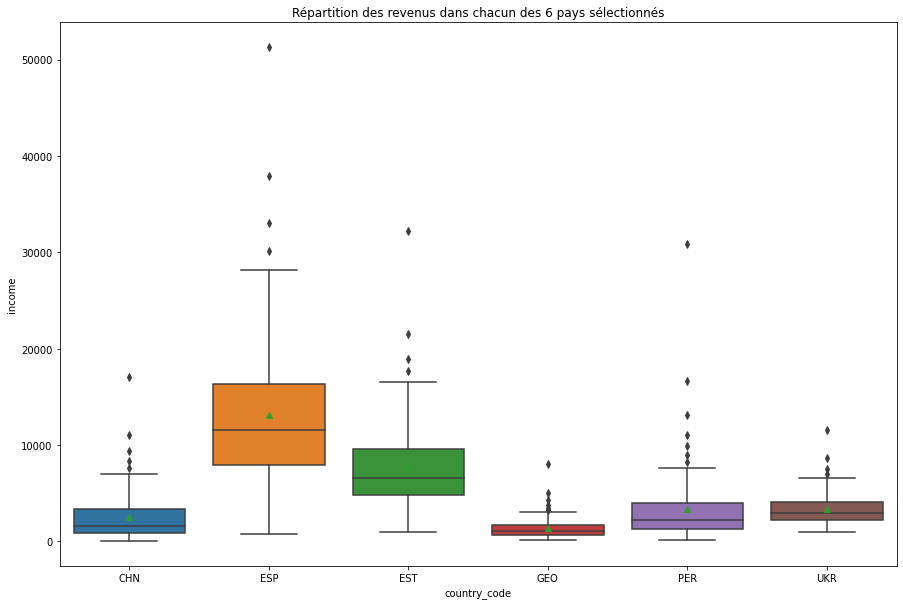

In [163]:
# Boxplot de la distribution des revenus dans chacun des 6 pays
plt.figure(figsize=(15,10))
sns.boxplot(x="country_code", y="income", data = data_select, showmeans=True)
plt.title("Répartition des revenus dans chacun des 6 pays sélectionnés")
plt.savefig('figure/Figure 22 - Répartition des revenus dans chacun des 6 pays sélectionnés')
plt.show()

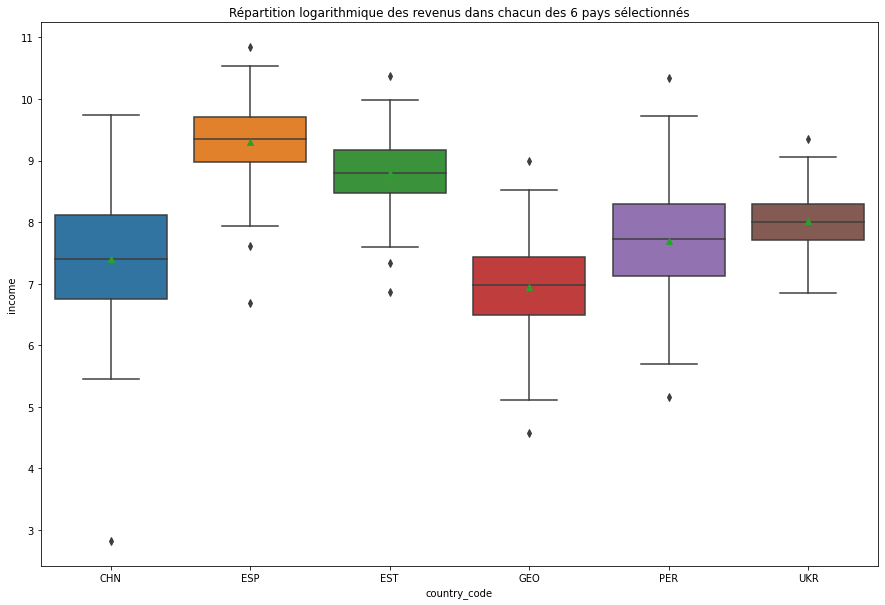

In [164]:
# Boxplot de la distribution logarithmique des revenus dans chacun des 6 pays
plt.figure(figsize=(15,10))
sns.boxplot(x="country_code", y="income", data = data_select_log, showmeans=True)
plt.title("Répartition logarithmique des revenus dans chacun des 6 pays sélectionnés")
plt.savefig('figure/Figure 23 - Répartition logarithmique des revenus dans chacun des 6 pays sélectionnés')
plt.show()

La projection logarithmique des valeurs permet de mieux constater les écarts entre les moyennes et l'étendu des revenus. Le pays semble donc bien impacter la variable des revenus. 
Les pays étant une variable catégorielle et le revenu une variable continue, nous allons réaliser une ANOVA pour mesurer encore davantage l'influence du pays sur les revenus.

#### Distribution des revenus dans l'ensemble des pays

In [165]:
# Conversion des dataframes en valeurs logarithmiques
log_data = data.copy()
log_data["income"] = np.log(log_data["income"])

log_data_clone = data_clone.copy()
log_data_clone["income"] = np.log(log_data_clone["income"])

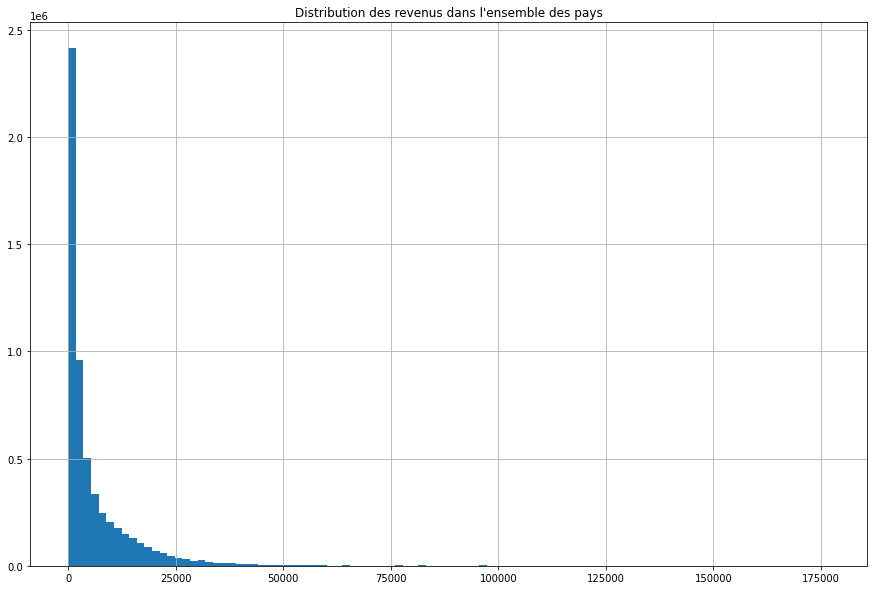

In [166]:
# Histogramme des revenus réels
plt.figure(figsize=(15,10))
data_clone.income.hist(bins=100)
plt.title("Distribution des revenus dans l'ensemble des pays")
plt.savefig('figure/Figure 24 - Distribution des revenus dans l\'ensemble des pays')
plt.show()

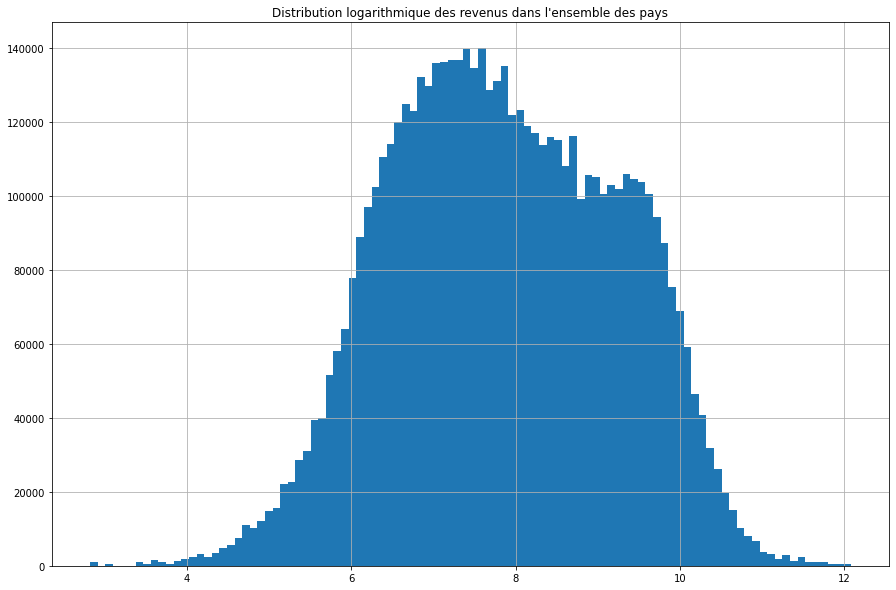

In [167]:
# Histogramme des revenus en valeurs logarithmiques
plt.figure(figsize=(15,10))
log_data_clone.income.hist(bins=100)
plt.title("Distribution logarithmique des revenus dans l'ensemble des pays")
plt.savefig('figure/Figure 25 - Distribution logarithmique des revenus dans l\'ensemble des pays')
plt.show()

La variable des revenus convertie en valeur logarithmique semble suivre une loi normale, à l'inverse de la distribution des revenus réels.

### ANOVA sur les revenus selon le pays d'appartenance 

In [168]:
# Anova du revenu des individus selon leur pays d'appartenance
anova_income = smf.ols('income ~ country_code', data=data).fit()
print(anova_income.summary())

                            OLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.491
Method:                 Least Squares   F-statistic:                     98.43
Date:                Mon, 06 Dec 2021   Prob (F-statistic):               0.00
Time:                        21:08:57   Log-Likelihood:            -1.1862e+05
No. Observations:               11600   AIC:                         2.375e+05
Df Residuals:                   11484   BIC:                         2.383e+05
Df Model:                         115                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            2994.8299    

In [169]:
# Anova du revenu en valeur logarithmique des individus selon leur pays d'appartenance
log_anova_income = smf.ols('income ~ country_code', data=log_data).fit()
print(log_anova_income.summary())

                            OLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.729
Model:                            OLS   Adj. R-squared:                  0.727
Method:                 Least Squares   F-statistic:                     269.0
Date:                Mon, 06 Dec 2021   Prob (F-statistic):               0.00
Time:                        21:08:57   Log-Likelihood:                -12627.
No. Observations:               11600   AIC:                         2.549e+04
Df Residuals:                   11484   BIC:                         2.634e+04
Df Model:                         115                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               7.8517    

Les p-valeurs (Prob F-statistic) étant inférieures à 0.05, elles indiquent que le résultat de notre régression par la méthode des moindres carrés est significatif dans les deux formes d'Anova.
L'Anova des valeurs logarithimiques explique cependant mieux la variance des revenus avec un R2 de 0.72 (72%), alors qu'avec les valeurs réelles, la régression explique 49% de la variance.

Pour que les résultats soient néanmoins valides, il est nécessaire que notre ANOVA satisfasse également trois conditions. Ces hypothèses de validité se vérifient sur les résidus selon les conditions suivantes:
- l'indépendance des résidus
- la normalité des résidus
- l'homogénéité des résidus (dispersion similaire ou variance constante)

#### Vérification des hypothèses de validité

- 1er test d'hypothèse: l'indépendance des résidus

Le test de Durbin-Watson s'élève à 0,38 et suggère une autocorrélation positive des résidus, mais comme ce test s'applique à des pays très différents on en déduit que les résidus sont indépendants

- 2e test d'hypothèse: la normalité des résidus

Le test de Shapiro mesure mal la significativité des dataframes de plus de 5000 lignes. Nous allons donc privilégier une analyse graphique des résidus

Le diagramme de probabilité permet notamment de contrôler visuellement si notre échantillon suit une distribution normale. 

C:\Users\Thibaut\anaconda3\envs\Python\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
C:\Users\Thibaut\anaconda3\envs\Python\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


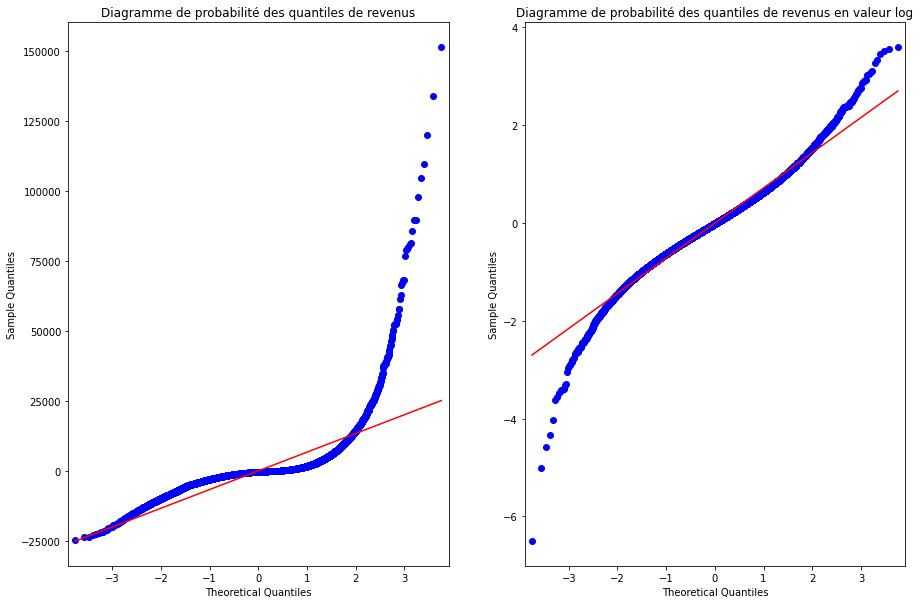

In [170]:
fig, (ax, ax2) = plt.subplots(ncols=2, figsize=(15,10))
fig1 = sm.qqplot(anova_income.resid, line='s', ax=ax)
fig2 = sm.qqplot(log_anova_income.resid, line="s", ax=ax2)
ax.set_title('Diagramme de probabilité des quantiles de revenus')
ax2.set_title('Diagramme de probabilité des quantiles de revenus en valeur log')
plt.savefig('figure/Figure 28 - Distribution des résidus de revenus selon le quantile')
plt.show()

Le diagramme de probabilité montre que les quantiles de revenus sont globalement alignés sauf pour les valeurs extrêmes.

Si nos valeurs ne suivent pas une loi normale, on ne peut plus interpréter les intervalles de confiance et les p-valeurs.
Cela pose problème dans le cas d'une prédiction.

In [171]:
stats.kstest(log_anova_income.resid, 'norm')

KstestResult(statistic=0.10815420141104568, pvalue=1.2752042783092507e-118)

Avec une p-valeur bien inférieure à 0.05, le test de Kolmogorov-Smirnov rejette l'hypothèse de normalité des résidus.

- 3e test d'hypothèse: l'homogénéité des résidus

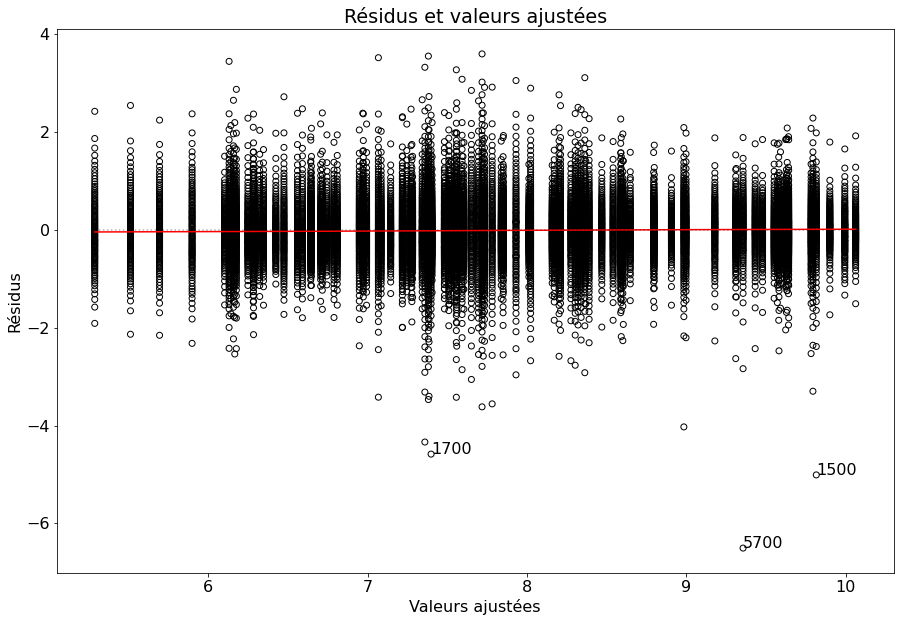

In [172]:
residuals = log_anova_income.resid
fitted = log_anova_income.fittedvalues
# LOESS: régression locale (alternative à la régression par les moindres carrés)
smoothed = lowess(residuals,fitted)
top3 = abs(residuals).sort_values(ascending = False)[:3]

plt.rcParams.update({'font.size': 16})
plt.rcParams["figure.figsize"] = (15,10)
fig, ax = plt.subplots()
ax.scatter(fitted, residuals, edgecolors = 'k', facecolors = 'none')
ax.plot(smoothed[:,0],smoothed[:,1],color = 'r')
ax.set_ylabel('Résidus')
ax.set_xlabel('Valeurs ajustées')
ax.set_title('Résidus et valeurs ajustées')
ax.plot([min(fitted),max(fitted)],[0,0],color = 'k',linestyle = ':', alpha = .3)

for i in top3.index:
    ax.annotate(i,xy=(fitted[i],residuals[i]))

plt.savefig('figure/Figure 29 - Résidus et valeurs ajustées')
plt.show()

Nous constatons une structure linéaire des résidus et une répartition assez équilibrée de la valeurs des résidus

Les 3 conditions sont respectées et valident l'anova

### Régression multiple des revenus individuels sur le revenu moyen du pays et l'indice de Gini

- Régression des revenus sur le PIB et l'indice de Gini

In [173]:
reg_multi_1 = smf.ols('income~GDP_ppp+Gini', data=data).fit()
print(reg_multi_1.summary())

                            OLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.447
Model:                            OLS   Adj. R-squared:                  0.447
Method:                 Least Squares   F-statistic:                     4696.
Date:                Mon, 06 Dec 2021   Prob (F-statistic):               0.00
Time:                        21:08:59   Log-Likelihood:            -1.1916e+05
No. Observations:               11600   AIC:                         2.383e+05
Df Residuals:                   11597   BIC:                         2.383e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -685.4132    338.859     -2.023      0.0

- Régression linéaire des revenus en valeur logarithmique sur le PIB-PPA et de l'indice de Gini

In [174]:
# Régression des revenus en valeur logarithmique sur le PIB-PPA et l'indice de Gini
reg_multi_log_1 = smf.ols('income~GDP_ppp+Gini', data=log_data).fit()
print(reg_multi_log_1.summary())

                            OLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.566
Model:                            OLS   Adj. R-squared:                  0.566
Method:                 Least Squares   F-statistic:                     7576.
Date:                Mon, 06 Dec 2021   Prob (F-statistic):               0.00
Time:                        21:08:59   Log-Likelihood:                -15357.
No. Observations:               11600   AIC:                         3.072e+04
Df Residuals:                   11597   BIC:                         3.074e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.0531      0.044    160.160      0.0

Sur les valeurs réelles ou logarithmiques, la p-valeur de nos Anovas demeure inférieure au seuil de 0.05. Cela signifie que le résultat de la régression multiple est significatif. Le R2 indique que la régression explique presque 45% de la variance du revenu réel par le PIB PPA et l'indice de Gini.
Le revenu en valeur logarithmique voit quant à lui sa variance expliquée à 56% selon le modèle de régression linéaire sur les variables PIB PPA et Gini.

#### Test d'hypothèse: normalité des résidus

C:\Users\Thibaut\anaconda3\envs\Python\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
C:\Users\Thibaut\anaconda3\envs\Python\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


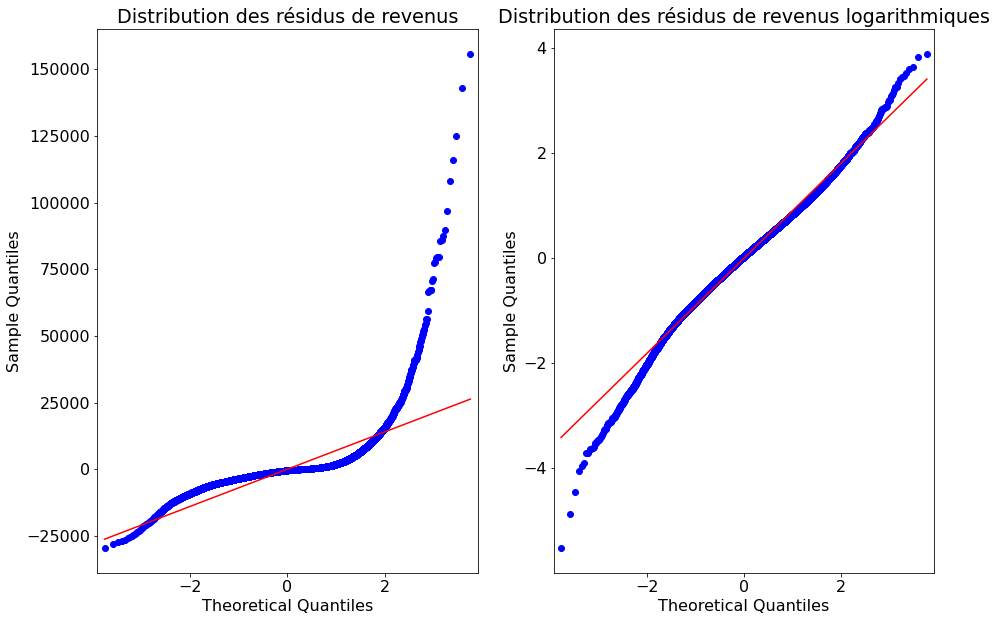

In [175]:
fig, (ax, ax2) = plt.subplots(ncols=2, figsize=(15,10))
fig1 = sm.qqplot(reg_multi_1.resid, line='s', ax=ax)
fig2 = sm.qqplot(reg_multi_log_1.resid, line="s", ax=ax2)
ax.set_title('Distribution des résidus de revenus')
ax2.set_title('Distribution des résidus de revenus logarithmiques')
plt.savefig('figure/Figure 32 - Distribution des résidus de revenus selon le quantile')
plt.show()

La représentation graphique de la distribution des résidus permet une meilleure analyse. On s'aperçoit en effet que la normalité est mieux respectée avec les valeurs logarithmiques (graphique de droite). On perçoit néanmoins que cette distribution s'écarte légèrement de la courbe de normalité au niveau des valeurs extrêmes.

#### Test d'hypothèse: homogénétité des résidus

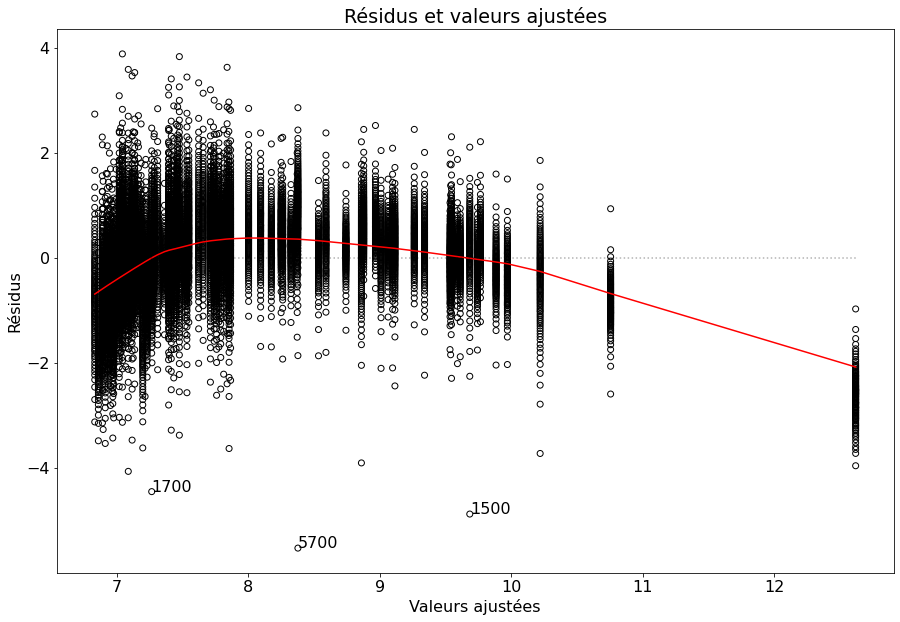

In [176]:
residuals = reg_multi_log_1.resid
fitted = reg_multi_log_1.fittedvalues
# LOESS: régression locale (alternative à la régression par les moindres carrés)
smoothed = lowess(residuals,fitted)
top3 = abs(residuals).sort_values(ascending = False)[:3]

plt.rcParams.update({'font.size': 16})
plt.rcParams["figure.figsize"] = (15,10)
fig, ax = plt.subplots()
ax.scatter(fitted, residuals, edgecolors = 'k', facecolors = 'none')
ax.plot(smoothed[:,0],smoothed[:,1],color = 'r')
ax.set_ylabel('Résidus')
ax.set_xlabel('Valeurs ajustées')
ax.set_title('Résidus et valeurs ajustées')
ax.plot([min(fitted),max(fitted)],[0,0],color = 'k',linestyle = ':', alpha = .3)

for i in top3.index:
    ax.annotate(i,xy=(fitted[i],residuals[i]))

plt.savefig('figure/Figure 33 - Résidus et valeurs ajustées')
plt.show()

Bien qu'un groupement d'individus se détache sur l'axe des valeurs ajustées, l'ensemble des résidus de notre modèle suit une structure linéaire assez nette.

### Régression linéaire incluant le quantile parent

In [177]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11600 entries, 0 to 11599
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country_code  11600 non-null  object 
 1   quantile      11600 non-null  Int64  
 2   nb_quantiles  11600 non-null  Int64  
 3   income        11600 non-null  float64
 4   GDP_ppp       11600 non-null  float64
 5   Gini          11600 non-null  float64
 6   Country Name  11600 non-null  object 
 7   pop_2008      11600 non-null  Int64  
 8   IGEincome     11600 non-null  float64
dtypes: Int64(3), float64(4), object(2)
memory usage: 1.2+ MB


In [178]:
# Conversion de la variable quantile en décimale pour la régression linéaire
data['quantile'] = data['quantile'].astype(float)

In [179]:
# Régression linéaire sur les valeurs réelles
reg_multi_2 = smf.ols('income~GDP_ppp+Gini+quantile', data=data).fit()
print(reg_multi_2.summary())

                            OLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.595
Method:                 Least Squares   F-statistic:                     5685.
Date:                Mon, 06 Dec 2021   Prob (F-statistic):               0.00
Time:                        21:09:01   Log-Likelihood:            -1.1735e+05
No. Observations:               11600   AIC:                         2.347e+05
Df Residuals:                   11596   BIC:                         2.347e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -7016.5511    305.914    -22.936      0.0

In [180]:
# Conversion de la variable quantile en décimale pour la régression linéaire
log_data['quantile'] = log_data['quantile'].astype(float)

In [181]:
# Régression linéaire sur les valeurs logarithmiques
reg_multi_log_2 = smf.ols('income~GDP_ppp+Gini+quantile', data=log_data).fit()
print(reg_multi_log_2.summary())

                            OLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                 1.524e+04
Date:                Mon, 06 Dec 2021   Prob (F-statistic):               0.00
Time:                        21:09:01   Log-Likelihood:                -10937.
No. Observations:               11600   AIC:                         2.188e+04
Df Residuals:                   11596   BIC:                         2.191e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.8913      0.032    185.654      0.0

Le résultat de la régression linéaire est significatif puisque dans les deux cas la p-valeur (Prob F-statistic) est inférieure au seuil de 0.05. 
En intégrant le quantile parent, la régression explique 59.5% de la variance des revenus réels, et même jusqu'à 80% de la variance s'agissant des revenus en valeur logarithmique.

#### Test d'hypothèse: colinéarité des variables

In [182]:
# Variance inflation factor (VIF)
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

# VIF pour le PIB PPA
vif(data[['GDP_ppp', 'Gini', 'quantile']].values, 0)

1.6472235526004106

In [183]:
# VIF pour le Gini
vif(data[['GDP_ppp', 'Gini', 'quantile']].values, 1)

3.695323763229937

In [184]:
# VIF pour les quantiles
vif(data[['GDP_ppp', 'Gini', 'quantile']].values, 2)

3.649885498428467

Aucune des 3 variables ne semble provoquer un excès de collinéarité car leurs VIF sont toutes inférieures à 5.

#### Test d'hypothèse: normalité des résidus

C:\Users\Thibaut\anaconda3\envs\Python\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
C:\Users\Thibaut\anaconda3\envs\Python\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


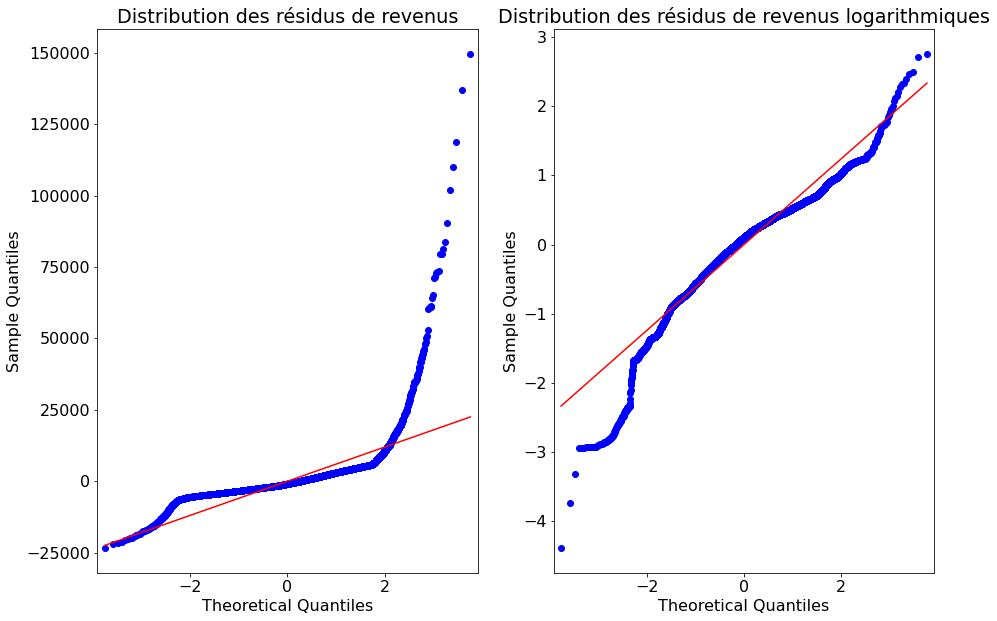

In [185]:
fig, (ax, ax2) = plt.subplots(ncols=2, figsize=(15,10))
fig1 = sm.qqplot(reg_multi_2.resid, line='s', ax=ax)
fig2 = sm.qqplot(reg_multi_log_2.resid, line="s", ax=ax2)
ax.set_title('Distribution des résidus de revenus')
ax2.set_title('Distribution des résidus de revenus logarithmiques')
plt.savefig('figure/Figure 36 - Distribution des résidus de revenus selon le quantile')
plt.show()

La représentation graphique semble mettre en évidence un défaut de normalité des résidus sur les extrémités.

#### Test d'hypothèse: homohénéité des résidus

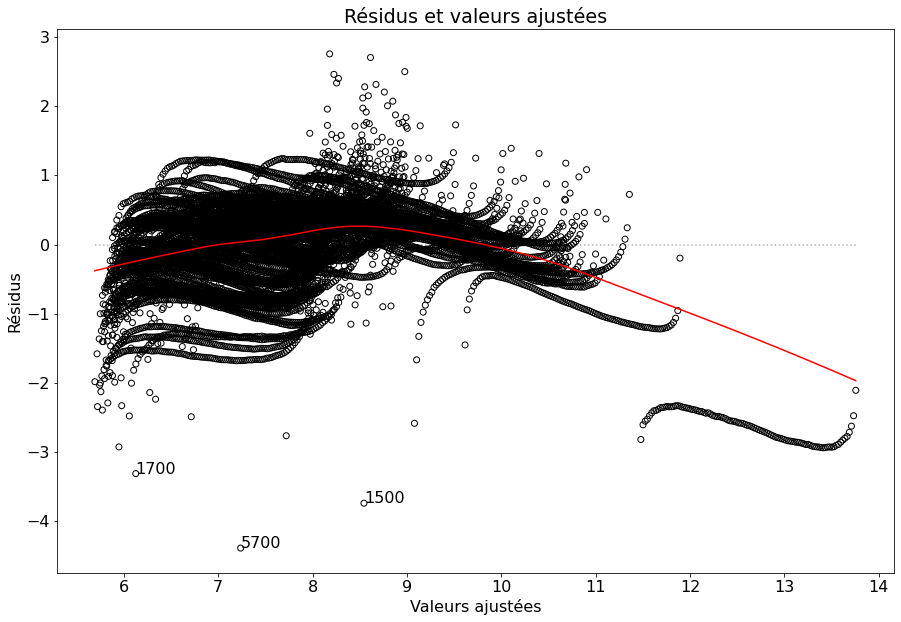

In [186]:
residuals = reg_multi_log_2.resid
fitted = reg_multi_log_2.fittedvalues
# LOESS: régression locale (alternative à la régression par les moindres carrés)
smoothed = lowess(residuals,fitted)
top3 = abs(residuals).sort_values(ascending = False)[:3]

plt.rcParams.update({'font.size': 16})
plt.rcParams["figure.figsize"] = (15,10)
fig, ax = plt.subplots()
ax.scatter(fitted, residuals, edgecolors = 'k', facecolors = 'none')
ax.plot(smoothed[:,0],smoothed[:,1],color = 'r')
ax.set_ylabel('Résidus')
ax.set_xlabel('Valeurs ajustées')
ax.set_title('Résidus et valeurs ajustées')
ax.plot([min(fitted),max(fitted)],[0,0],color = 'k',linestyle = ':', alpha = .3)

for i in top3.index:
    ax.annotate(i,xy=(fitted[i],residuals[i]))

plt.savefig('figure/Figure 37 - Résidus et valeurs ajustées')
plt.show()

Sans être parfaitement homogènes, les données suivent un pattern clair peu dispersé.

Nos trois hypothèses sont vérifiées et confirment la validité de notre régression.

### Prédiction du revenus selon le pays et le quantile d'un individu.

Pour tester l'influence de l'indice de Gini sur le niveau de revenus, nous allons simuler une forte augmentation de cet indice dans un pays à l'indice de Gini relativement bas: la France. Nous allons ainsi observer quel niveau de revenus est prédit par notre modèle pour un individu ayant un niveau de revenus médian (du cinquantième centile) avant et après l'augmentation de l'indice de Gini.

En 2008, l'indice de Gini de la France s'élevait à 0.33 et le PIB (PPA) annuel était de 30 357$ par habitant.

In [187]:
round(np.exp(reg_multi_log_2.predict({'Gini' : [0.33],
                                      'GDP_ppp':[30357],
                                      'quantile':[50]})), 2)

0    10404.82
dtype: float64

Selon notre modèle, un individu appartenant au centile 29 en France a donc un revenu moyen de 10 404 USD.

In [188]:
round(np.exp(reg_multi_log_2.predict({'Gini' : [0.8],
                                      'GDP_ppp':[30357],
                                      'quantile':[50]})), 2)

0    8272.08
dtype: float64

Si en revanche lindice de Gini était de 0.8, son revenu moyen diminuerait à 8 272 USD.

Nous observons qu'un passage de l'indice de Gini de 0,33 à 0,8 réduit assez significativement le niveau de revenus d'un individu du cinquantième centile. Le modèle de régression suggère donc que dans une société inégalitaire, plus de la moitié de la population voit son niveau de revenus se dégrader.

Note : Nous aurions préféré appliquer notre modèle de régression sur le dataset incluant les clones générés selon les résultats des probabilités conditionnelles. Malheuremsement, un calcul sur un tel dataframe exige un usage de mémoire trop élevé. Nous avons donc testé la réalisation d'une régression sur les 6 pays ultérieurement sélectionnés pour caractériser les principales tendances mondiales de la répartition des revenus.

### Régression à partir du dataframe incluant les individus clonés.

In [189]:
pays_select

['CHN', 'GEO', 'PER', 'ESP', 'UKR', 'EST']

In [190]:
data_clone.shape

(5723195, 10)

In [191]:
data_clone_select = data_clone.loc[data_clone['country_code'].isin(pays_select)]

In [192]:
# Modification pour faciliter l'utilisation de la fonction de régression linéaire
data_clone_select.rename(columns={'quantile parent':'quantile_parent'}, inplace=True)

C:\Users\Thibaut\anaconda3\envs\Python\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [193]:
# Régression linéaire sur les valeurs réelles
reg_multi_3 = smf.ols('income~GDP_ppp+Gini+quantile_parent', data=data_clone_select).fit()
print(reg_multi_3.summary())

                            OLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.535
Model:                            OLS   Adj. R-squared:                  0.535
Method:                 Least Squares   F-statistic:                 1.139e+05
Date:                Mon, 06 Dec 2021   Prob (F-statistic):               0.00
Time:                        21:09:31   Log-Likelihood:            -2.8824e+06
No. Observations:              297025   AIC:                         5.765e+06
Df Residuals:                  297021   BIC:                         5.765e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -2433.1689     43.965    -

In [194]:
# Conversion des revenus en valeurs logarithmiques
log_data_clone_select = data_clone_select.copy()
log_data_clone_select['income'] = np.log(log_data_clone_select['income'])

In [195]:
# Régression linéaire sur les valeurs logarithmiques
reg_multi_log_3 = smf.ols('income~GDP_ppp+Gini+quantile_parent', data=log_data_clone_select).fit()
print(reg_multi_log_3.summary())

                            OLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.596
Model:                            OLS   Adj. R-squared:                  0.596
Method:                 Least Squares   F-statistic:                 1.458e+05
Date:                Mon, 06 Dec 2021   Prob (F-statistic):               0.00
Time:                        21:09:32   Log-Likelihood:            -3.1275e+05
No. Observations:              297025   AIC:                         6.255e+05
Df Residuals:                  297021   BIC:                         6.256e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           7.2272      0.008    9

Avec une p-valeur inférieure au seuil de 0.05, nos modèles de régression sont tous deux statistiquement significatifs. Le 1er modèle avec les valeurs réelles explique 53.5% de la variation des revenus dans les 6 pays sélectionnés, tandis que le 2e modèle avec les valeurs logarithmiques explique 59.6% de la variation des revenus.

Cela signifie que dans le 1er modèle, 46.5% de la variation des revenus peut s'expliquer par d'autres facteurs non considérés par notre modèle. Dans le 2e modèle, ces facteurs non considérés interviennent dans 40.4% des variations de valeurs.

#### Vérification des hypothèses de validité

- 1er test d'hypothèse: l'indépendance des résidus

Le test de Durbin-Watson s'élève à 0,38 et suggère une autocorrélation positive des résidus, mais comme ce test s'applique à des pays très différents on en déduit que les résidus sont indépendants

- 2e test d'hypothèse: la normalité des résidus

Le test de Shapiro mesure mal la significativité des dataframes de plus de 5000 lignes. Nous allons donc privilégier une analyse graphique des résidus

Le diagramme de probabilité permet notamment de contrôler visuellement si notre échantillon suit une distribution normale. 

C:\Users\Thibaut\anaconda3\envs\Python\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
C:\Users\Thibaut\anaconda3\envs\Python\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


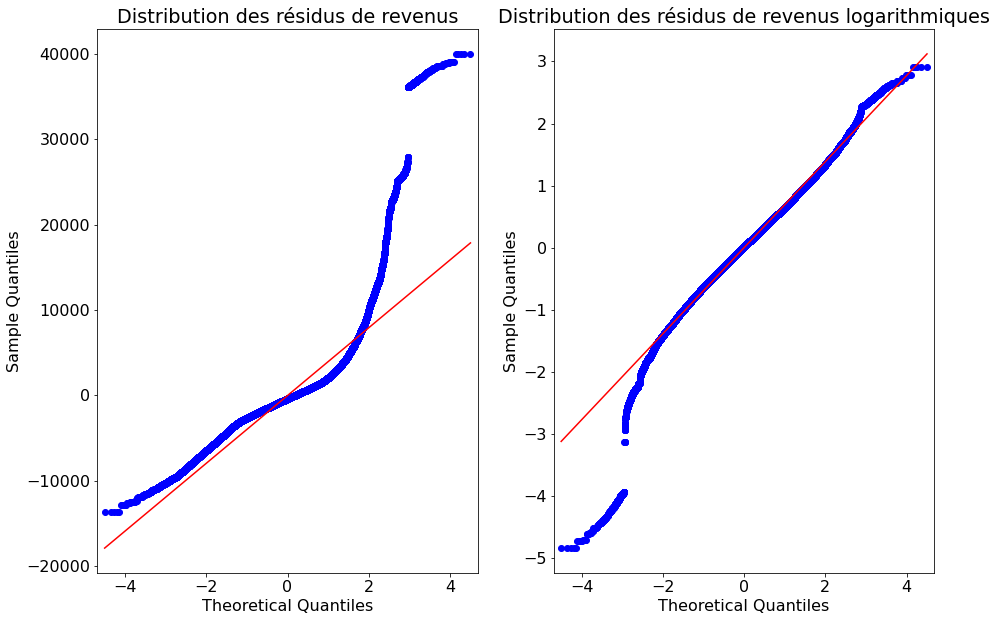

In [196]:
fig, (ax, ax2) = plt.subplots(ncols=2, figsize=(15,10))
fig1 = sm.qqplot(reg_multi_3.resid, line='s', ax=ax)
fig2 = sm.qqplot(reg_multi_log_3.resid, line="s", ax=ax2)
ax.set_title('Distribution des résidus de revenus')
ax2.set_title('Distribution des résidus de revenus logarithmiques')
plt.savefig('figure/Figure 40 - Distribution des résidus de revenus selon le quantile')
plt.show()

Les résidus des premiers quantiles dévient significativement de la loi de normalité, mais le diagramme de probabilité montre dans son ensemble qu'une partie importante des quantiles de revenus reste alignée. Nos valeurs semblent globalement suivre une loi normale.

Si nos valeurs ne suivent pas une loi normale, on ne peut plus interpréter les intervalles de confiance et les p-valeurs.
Cela pose problème dans le cas d'une prédiction.

- 3e test d'hypothèse: l'homogénéité des résidus

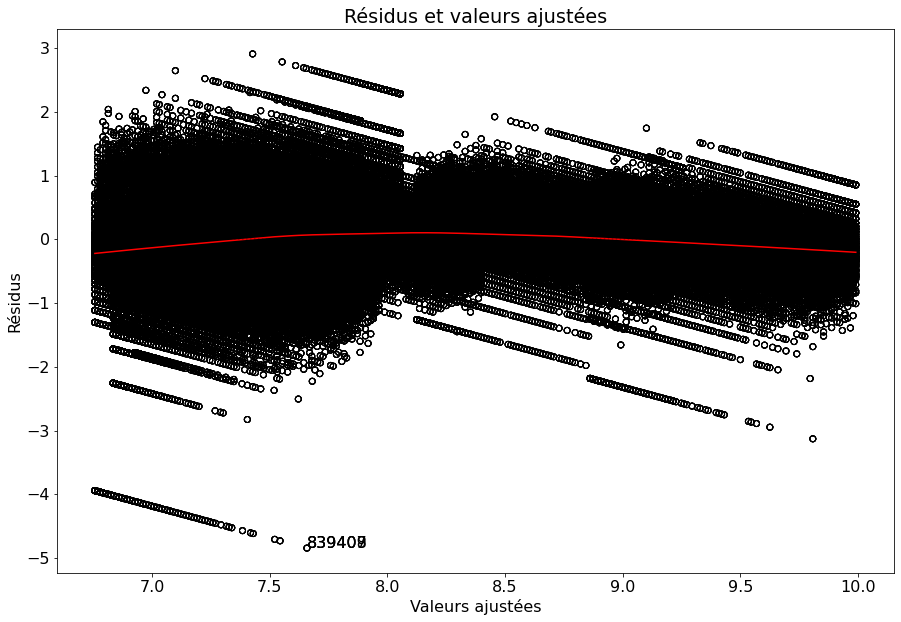

In [197]:
residuals = reg_multi_log_3.resid
fitted = reg_multi_log_3.fittedvalues
# LOESS: régression locale (alternative à la régression par les moindres carrés)
smoothed = lowess(residuals,fitted)
top3 = abs(residuals).sort_values(ascending = False)[:3]

plt.rcParams.update({'font.size': 16})
plt.rcParams["figure.figsize"] = (15,10)
fig, ax = plt.subplots()
ax.scatter(fitted, residuals, edgecolors = 'k', facecolors = 'none')
ax.plot(smoothed[:,0],smoothed[:,1],color = 'r')
ax.set_ylabel('Résidus')
ax.set_xlabel('Valeurs ajustées')
ax.set_title('Résidus et valeurs ajustées')
ax.plot([min(fitted),max(fitted)],[0,0],color = 'k',linestyle = ':', alpha = .3)

for i in top3.index:
    ax.annotate(i,xy=(fitted[i],residuals[i]))

plt.savefig('figure/Figure 41 - Résidus et valeurs ajustées')
plt.show()

A l'exception de quelques éléments mineurs, nous constatons une répartition assez équilibrée de la valeurs des résidus de part et d'autre de la ligne de normalité.

Les 3 conditions sont donc respectées et valident ce modèle de régression.

### Analyse des valeurs influentes

Nous allons ici réaliser nos tests à un niveau alpha: 𝛼 = 5%.
Avec n le nombre d'individus de notre échantillon et p le nombre de variables.

In [198]:
alpha = 0.05
n = data.shape[0]
p = 4

In [199]:
# Création d'un dataframe dédié à l'analyse des valeurs influentes
analyses = pd.DataFrame({'obs':np.arange(1,n+1)})
# analyses['obs'].astype('float', inplace=True)

#### Calcul des leviers

Les effets de levier permettent de détecter les valeurs de prédicteurs étant éloignés du vecteur de moyenne.
Le seuil des leviers est ici de 2𝑝/𝑛.

Création d'un dataframe 'analyses' à partir duquel nous allons mener des analyses sur les valeurs influentes:

In [215]:
analyses['levier'] = reg_multi_log_2.get_influence().hat_matrix_diag

seuil_levier = 2*p/n

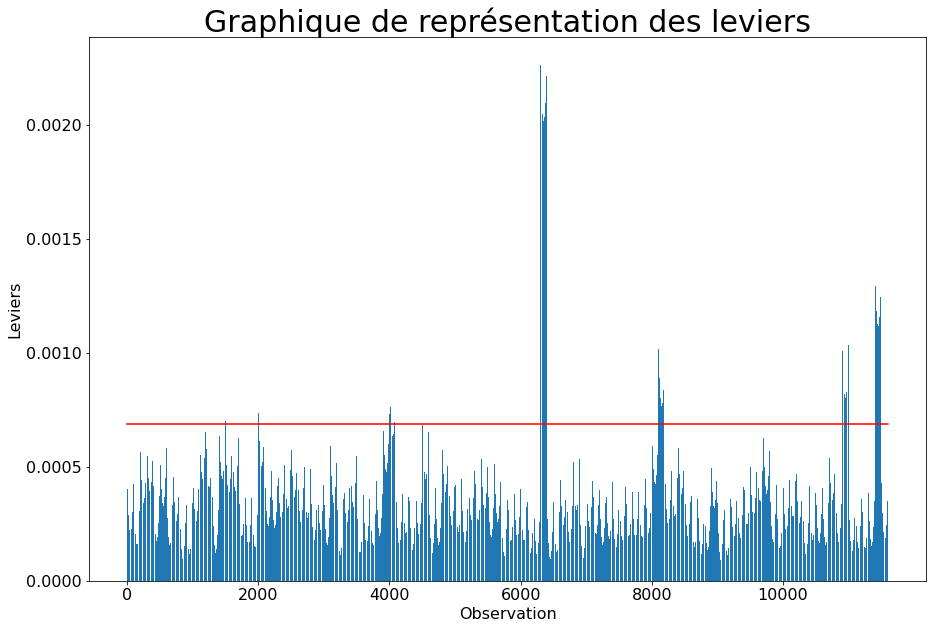

In [231]:
# Graphique de représentation des leviers
plt.figure(figsize=(15,10))
plt.bar(analyses['obs'], analyses['levier'])
plt.xticks(np.arange(0, 11600, step=2000))
plt.xlabel('Observation')
plt.ylabel('Leviers')
plt.title('Graphique de représentation des leviers', size=30)
plt.plot([0, 11600], [seuil_levier, seuil_levier], color='r')
plt.savefig('figure/Figure 42 - Graphique de représentation des leviers')
plt.show()

Plusieurs valeurs dépassent le seuil de levier. Une en particulier se détache fortement de la moyenne.

In [217]:
# Identification des individus pour lesquels le levier est supérieur au seuil:
analyses.loc[analyses['levier'] > seuil_levier, :]

,obs,levier,rstudent,dcooks
1100,1101,0.000702,-0.321415,0.000015
1101,1102,0.000691,-0.316188,0.000015
1198,1199,0.000691,2.238916,0.000749
1199,1200,0.000702,5.934056,0.005262
1400,1401,0.000701,-0.091740,0.000001
...,...,...,...,...
11495,11496,0.001330,2.764780,0.002847
11496,11497,0.001340,3.380218,0.004255
11497,11498,0.001349,4.365649,0.007098
11498,11499,0.001359,5.873627,0.012848


Ce sont 490 individus sur les 11 600 du dataframe qui ont leur valeur se détachant nettement de la moyenne, soit 4.2% de notre échantillon.

In [218]:
490/11600*100

4.224137931034483

#### Calcul des résidus studentisés

Test détectant la présence d'observations atypiques.
Le seuil pour les résidus studentisés est une loi de Student à n-p-1 degrés de liberté:

Création d'un dataframe 'analyses' à partir duquel nous allons mener des analyses sur les valeurs influentes:

In [219]:
analyses['rstudent'] = reg_multi_log_2.get_influence().resid_studentized_internal
seuil_rstudent = t.ppf(1-alpha/2,n-p-1)

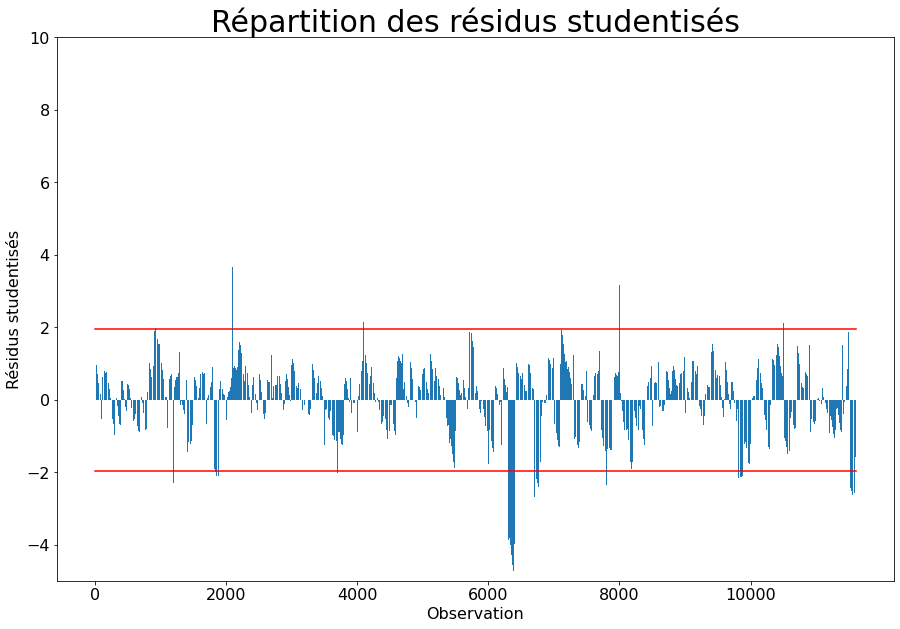

In [232]:
# Représentation graphique des résidus studentisés comparés aux bornes + ou - 2.
plt.figure(figsize=(15,10))
plt.bar(analyses['obs'], analyses['rstudent'])
plt.xticks(np.arange(0, 11600, step=2000))
plt.xlabel('Observation')
plt.ylabel('Résidus studentisés')
plt.ylim((-5,10))
plt.title('Répartition des résidus studentisés', size=30)
plt.plot([0, 11600], [seuil_rstudent, seuil_rstudent], color='r')
plt.plot([0, 11600], [-seuil_rstudent, -seuil_rstudent], color='r')
plt.savefig('figure/Figure 43 - Répartition des résidus studentisés')
plt.show()

In [221]:
analyses.loc[analyses['rstudent'] > seuil_rstudent, :]

,obs,levier,rstudent,dcooks
199,200,0.000408,2.704866,1.449745e-03
899,900,0.000344,2.109286,3.207305e-04
918,919,0.000219,1.962540,4.395451e-07
919,920,0.000212,1.972326,3.457435e-07
920,921,0.000206,1.967240,2.868295e-07
...,...,...,...,...
11495,11496,0.001330,2.554638,2.846719e-03
11496,11497,0.001340,2.777756,4.255130e-03
11497,11498,0.001349,3.085656,7.097758e-03
11498,11499,0.001359,3.464999,1.284802e-02


In [222]:
106/11600*100

0.9137931034482759

Nous décelons 106 observations potentiellement influentes par la taille des résidus. Cela représente 0.9% de notre dataframe.

#### Distance de Cook

La distance de Cook est un paramètre qui mesure l'influence d'une observation sur l'ensemble des prévision en prenant en compte effet levier et importance des résidus.

In [223]:
# Instance de méthodes pour calculer l'influence des points de la régression
influence = reg_multi_log_2.get_influence().summary_frame()

In [224]:
# Seuil de la distance de Cook à n-p
analyses['dcooks'] = influence['cooks_d']
seuil_dcook = 4/(n-p)

In [225]:
seuil_dcook

0.00034494653328734045

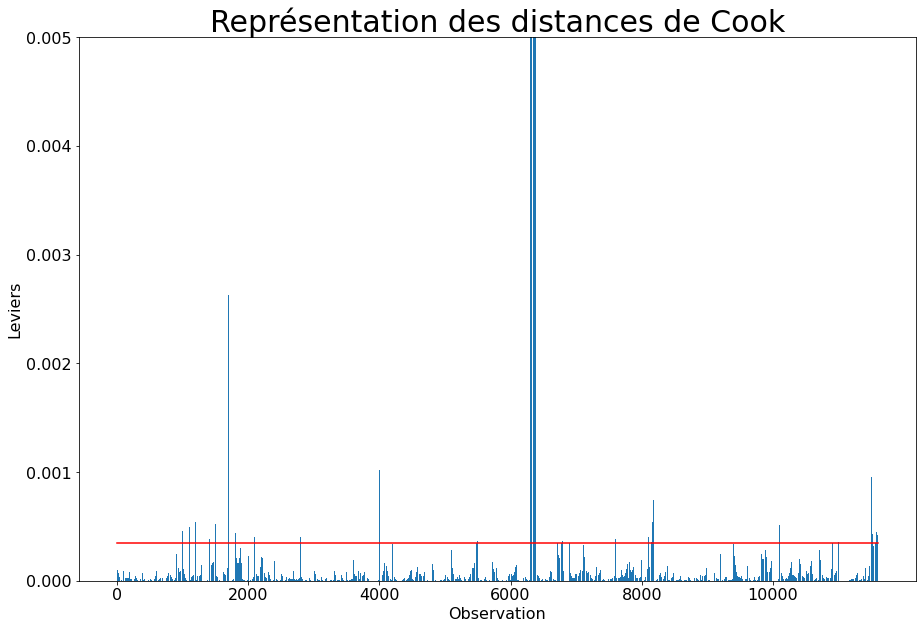

In [233]:
# Détection des observations influentes comme ceci:
plt.figure(figsize=(15,10))
plt.bar(analyses['obs'], analyses['dcooks'])
plt.xticks(np.arange(0, 11600, step=2000))
plt.xlabel('Observation')
plt.ylabel('Leviers')
plt.ylim((0,0.005))
plt.title('Représentation des distances de Cook', size=30)
plt.plot([0, 11600], [seuil_dcook, seuil_dcook], color='r')
plt.savefig('figure/Figure 44 - Graphique de représentation des distances de Cook')
plt.show()

In [229]:
len(analyses.loc[analyses['dcooks'] > seuil_dcook])

501

In [230]:
501/11600*100

4.318965517241379

4.3% des individus de notre échantillon dépassent le seuil de la distance de Cook

In [228]:
len(analyses.loc[(analyses['levier'] > seuil_levier) & 
             (analyses['rstudent'] > seuil_rstudent) &
            (analyses['dcooks'] > seuil_dcook)])/11600*100

0.1724137931034483

0.17% des individus cumulent un dépassement du seuil de chacun des trois paramètres.

## Bibliographie

- Tests des modèles de régression avec statsmodels:
https://www.statsmodels.org/devel/examples/notebooks/generated/regression_diagnostics.html


- Méthode des moindres carrés sur Python (ordinary least squares):
https://www.datarobot.com/blog/ordinary-least-squares-in-python/


- Vérification d'une régression linéaire sur Python et R:
https://towardsdatascience.com/verifying-the-assumptions-of-linear-regression-in-python-and-r-f4cd2907d4c0


- Non-satisfaction des hypothèses dans une régression linéaire simple:
https://delladata.fr/regression-lineaire-simple-quand-les-hypotheses-ne-sont-pas-satisfaites/


- Interprétation des résultats d'une régression linéaire:
https://www.accelebrate.com/blog/interpreting-results-from-linear-regression-is-the-data-appropriate


- Effets de levier ou distance de Cook. Quel pourcentage des points sont influents?: https://openclassrooms.com/fr/courses/4525326-realisez-des-modelisations-de-donnees-performantes/5754146-tp-pratiquez-la-regression-lineaire-multiple-sur-le-jeu-de-donnees-de-lozone

#### Rappel de la signification des différents tests (valable en général pour des données de moins de 5000 lignes):
- Test Omnibus de comparaison de population testant l'homogénéité des variances (on espère une valeur inférieure à prob(omnibus)
- Prob(omnibus): probabilité que que les résidus soient normalement distribués (proche de 1)
- Skew: mesure la symétrie des données (une valeur proche de 0 indique une distribution normale des résidus)
- Kurtosis: mesure la courbure des données. Une valeur haute indique un clustering plus rapproché avec des résidus proches de la moyenne et un faible nombre d'outliers
- Durbin Watson: test d'autocorrélation des résidus dans un modèle de régression linéaire (non auto-corrélation avec p=0)
- Jarque Bera (JB) / Prob(JB): comme l'omnibus, ils testent l'inclinaison et l'aplatissement des données. On espère identifier une confirmation des tests omnibus.
- Condition number: ce test mesure la sensibilité de la variable de prédiction par rapport à la variable de résultat (on espère généralement trouver un nombre inférieur à 30)